In [1]:
import pandas as pd
import networkx as nx
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import json
import igraph as ig
import leidenalg as la
import itertools
import math
import powerlaw
import scipy.sparse as sp
import statsmodels.api as sm
import random
import heapq
import copy
import pickle
import joblib
from datetime import datetime, timedelta
from venn import venn
from scipy.stats import pearsonr, spearmanr, kendalltau, ttest_ind
from collections import Counter, defaultdict
from itertools import combinations
from sklearn.metrics import silhouette_score, normalized_mutual_info_score, adjusted_mutual_info_score, adjusted_rand_score
from math import log2
from multiprocessing import Pool, cpu_count

In [2]:
plt.rcdefaults()

## Data preparation

In [3]:
transfers_df = pd.read_csv('data/1_year/reduced_transfers_1_year.csv')

def filter_votes(data):
    for proposal in data:
        proposal['votes'] = [vote for vote in proposal['votes'] if float(vote['weight']) > 0]
        
    return data

with open('data/proposals/compound/compound_proposals_1_year.json', 'r', encoding='utf8') as file:
    comp_proposals = json.load(file)['data']['proposals']
    
with open('data/proposals/compound/compound_votes_1_year.json', 'r', encoding='utf8') as file:
    comp_votes = filter_votes(json.load(file))
    
with open('data/proposals/compound/compound_delegations.json', 'r', encoding='utf8') as file:
    delegations = json.load(file)['data']['delegateChanges']
    
delegations = [
    entry for entry in delegations
    if 1696118399 < int(entry['blockTimestamp']) < 1727740800
]

In [4]:
COMP_tokens = ['COMP', 'PolCOMP', 'ArbCOMP']
cTokens = ['cWETHv3', 'cArbWETH'] #, 'cUSDTv3', 'cUSDCv3', 'cPolUSDT', 'cArbUSDC', 'cArbUSDT']

comp_df = transfers_df[
    transfers_df['token'].isin(COMP_tokens) &
    (transfers_df['from'].str.lower() != transfers_df['to'].str.lower()) &
    (transfers_df['value'] != 0)
]
cToken_df = transfers_df[
    transfers_df['token'].isin(cTokens) &
    (transfers_df['from'].str.lower() != transfers_df['to'].str.lower()) &
    (transfers_df['value'] != 0)
]

## Network construction

### Most important networks

In [5]:
# COMP GRAPH AGGREGATED BY TRANSFER VALUES

G_comp = nx.DiGraph()

for _, row in comp_df.iterrows():
    from_address = row['from'].lower()
    to_address = row['to'].lower()
    value = row['value']
    
    if G_comp.has_edge(from_address, to_address):
        G_comp[from_address][to_address]['weight'] += value
    else:
        G_comp.add_edge(from_address, to_address, weight=value)
        
G_comp_nodes = G_comp.nodes()

In [6]:
# COMP TWMDG

G_comp_complete = nx.MultiDiGraph()

for _, row in comp_df.iterrows():
    from_address = row['from'].lower()
    to_address = row['to'].lower()
    value = row['value']
    timestamp = row['timestamp']
    
    G_comp_complete.add_edge(from_address, to_address, weight=value, timestamp=timestamp)

In [7]:
# COMP GRAPH AGGREGATED BY NUMBER OF TRANSFERS

G_comp_count = nx.DiGraph()

for _, row in comp_df.iterrows():
    from_address = row['from'].lower()
    to_address = row['to'].lower()
    
    if G_comp_count.has_edge(from_address, to_address):
        G_comp_count[from_address][to_address]['weight'] += 1
    else:
        G_comp_count.add_edge(from_address, to_address, weight=1)

In [8]:
# cWETH GRAPH AGGREGATED BY TRANSFER VALUES

G_cWETH = nx.DiGraph()

for _, row in cToken_df.iterrows():
    from_address = row['from'].lower()
    to_address = row['to'].lower()
    value = row['value']
    
    if G_cWETH.has_edge(from_address, to_address):
        G_cWETH[from_address][to_address]['weight'] += value
    else:
        G_cWETH.add_edge(from_address, to_address, weight=value)

### Governance data

In [9]:
vote_counts = {}
for votes in comp_votes:
    for vote in votes['votes']:
        voter = vote['voter'].get('id')
        if voter in vote_counts:
            vote_counts[voter] += 1
        else:
            vote_counts[voter] = 1

vote_weights = {}
for votes in comp_votes:
    for vote in votes['votes']:
        voter = vote['voter'].get('id')
        weight = vote['weight']
        if voter in vote_weights:
            vote_weights[voter] += float(weight)
        else:
            vote_weights[voter] = float(weight)
            
delegation_counts = {}
from_delegations = {}
to_delegations = {}

for delegation in delegations:
    delegator = delegation['delegator'].lower()
    if delegator in delegation_counts:
        delegation_counts[delegator] += 1
    else:
        delegation_counts[delegator] = 1
        
    if delegator in from_delegations:
        from_delegations[delegator] += 1
    else:
        from_delegations[delegator] = 1
                
    delegate = delegation['delegate'].lower()
    if delegate in delegation_counts:
        delegation_counts[delegate] += 1
    else: 
        delegation_counts[delegate] = 1
        
    if delegate in to_delegations:
        to_delegations[delegate] += 1
    else:
        to_delegations[delegate] = 1

In [10]:
for voter in vote_weights:
    vote_weights[voter] = vote_weights[voter] / vote_counts[voter]

In [11]:
proposers = set()

for proposal in comp_proposals:
    proposers.add(proposal['proposer']['id'])
    
proposers = proposers & G_comp_nodes

In [12]:
voters = set()

for votes in comp_votes:
    for vote in votes['votes']:
        voters.add(vote['voter'].get('id'))
        
voters_in_G_comp = voters & G_comp_nodes

In [13]:
delegators = set()
delegates = set()

from_delegations_without_same_to = set()
to_delegations_without_same_from = set()

for delegate in delegations:
    delegator = delegate['delegator']
    delegate = delegate['delegate']
    
    delegators.add(delegator)
    delegates.add(delegate)
    
    if delegator != delegate:
        from_delegations_without_same_to.add(delegator)
        to_delegations_without_same_from.add(delegate)    
    
all_delegations = (delegators | delegates) & G_comp_nodes

In [17]:
cWETH_users = (set(cToken_df['from'].unique()) | set(cToken_df['to'].unique()))
COMP_users = (set(comp_df['from'].unique()) | set(comp_df['to'].unique()))
# all_governance_users = proposers | delegators | delegates
# all_governance_users_in_G_comp = all_governance_users & G_comp_nodes
all_voters_in_G_comp = voters & G_comp_nodes
all_voters_delegators_in_G_comp = (voters | delegators) & G_comp_nodes

In [18]:
non_governance_users = G_comp_nodes - proposers - voters - all_delegations
# governance_users = proposers | voters | all_delegations
all_economic_users = set(cToken_df['from'].str.lower()) | set(cToken_df['to'].str.lower())
all_economic_users_in_G_comp = (set(cToken_df['from'].str.lower()) | set(cToken_df['to'].str.lower())) & G_comp_nodes

In [56]:
only_economic_users_in_G_comp = all_economic_users_in_G_comp - all_voters_in_G_comp
# only_governance_users = all_governance_users_in_G_comp - all_economic_users_in_G_comp
only_voters_in_G_comp = all_voters_in_G_comp - all_economic_users_in_G_comp
both_economic_and_governance_users = all_economic_users_in_G_comp & all_voters_in_G_comp

In [19]:
# For SI analysis
SI_governance_users = ((voters | delegators) - cWETH_users) & G_comp_nodes
SI_economic_users = (cWETH_users - (voters | delegators)) & G_comp_nodes
SI_both_users = (cWETH_users & (voters | delegators)) & G_comp_nodes
SI_none_users = (G_comp_nodes - cWETH_users) - (voters | delegators)

In [21]:
print(f'Total: {len(G_comp_nodes)}\nProposers: {len(proposers)}\nVoters: {len(voters)}\nDelegations: {len(all_delegations)}\nGovernance: {len(only_governance_users)}\nEconomic: {len(only_economic_users)}')

Total: 74472
Proposers: 5
Voters: 248
Delegations: 457
Governance: 434
Economic: 4791


## Manual feature computations

In [20]:
G_cWETH_igraph = ig.Graph.from_networkx(G_cWETH, vertex_attr_hashable='name')
G_comp_igraph = ig.Graph.from_networkx(G_comp, vertex_attr_hashable='name')

### DC

In [21]:
cWETH_igraph_in_dc = [d for d in G_cWETH_igraph.indegree()]
cWETH_igraph_out_dc = [d for d in G_cWETH_igraph.outdegree()]

cWETH_igraph_in_dc = {G_cWETH_igraph.vs[i]["name"]: score for i, score in enumerate(cWETH_igraph_in_dc)}
cWETH_igraph_out_dc = {G_cWETH_igraph.vs[i]["name"]: score for i, score in enumerate(cWETH_igraph_out_dc)}

comp_igraph_in_dc = [d for d in G_comp_igraph.indegree()]
comp_igraph_out_dc = [d for d in G_comp_igraph.outdegree()]

comp_igraph_in_dc = {G_comp_igraph.vs[i]["name"]: score for i, score in enumerate(comp_igraph_in_dc)}
comp_igraph_out_dc = {G_comp_igraph.vs[i]["name"]: score for i, score in enumerate(comp_igraph_out_dc)}

### Eigenvector centrality

In [22]:
def eigenvector_manual(graph, tol=1e-6, max_iter=100):    
    n = graph.vcount()
    edges = np.array(graph.get_edgelist())
    weights = np.array(graph.es["weight"])

    row, col = edges[:, 1], edges[:, 0]
    W = sp.csr_matrix((weights, (row, col)), shape=(n, n))

    x = np.ones(n)
    for _ in range(max_iter):
        x_new = W @ x
        x_new /= np.linalg.norm(x_new, ord=2)
        
        if np.linalg.norm(x_new - x, ord=2) / np.linalg.norm(x, ord=2) < tol:
            break
        
        x = x_new

    return {graph.vs[i]["name"]: x[i] for i in range(n)}

cWETH_igraph_ec = eigenvector_manual(G_cWETH_igraph)
comp_igraph_ec = eigenvector_manual(G_comp_igraph)

### Local clustering coefficient

In [23]:
def clustering_manual(graph):
    n = graph.vcount()
    
    W_sparse = graph.get_adjacency_sparse(attribute='weight').tocsc()
    W13 = W_sparse.power(1/3)
    W13_T = W13.transpose()
    
    W_sum = W13 + W13_T
    W_sum.data **= 3
    numerator = np.array(W_sum.sum(axis=1)).flatten()
    
    d_out = np.array(graph.outdegree())
    d_in = np.array(graph.indegree())
    d_tot = d_out + d_in
    
    A_sparse = graph.get_adjacency_sparse().tocsc()
    mutual_edges = np.array(A_sparse.multiply(A_sparse.T).sum(axis=1)).flatten()
    
    denominator = 2 * (d_tot * (d_tot - 1) - 2 * mutual_edges)
    
    with np.errstate(divide='ignore', invalid='ignore'):
        C = np.where(denominator > 0, numerator / denominator, 0)
    
    return {graph.vs[i]["name"]: C[i] for i in range(n)}

cWETH_igraph_cc = clustering_manual(G_cWETH_igraph)
comp_igraph_cc = clustering_manual(G_comp_igraph)

### 2-hop neighbors

In [24]:
def two_hop_weight_sum_ig(G):
    weight_sums = [0] * G.vcount()

    for node in range(G.vcount()):
        visited = set()
        total_weight = 0

        neighbors = set(G.neighborhood(node, order=1, mode='ALL'))

        for n in neighbors:
            for e in G.incident(n, mode='ALL'):
                if e not in visited:
                    total_weight += G.es[e]['weight']
                    visited.add(e)

        weight_sums[node] = total_weight

    return {G.vs[i]["name"]: weight_sums[i] for i in range(G.vcount())}

In [ ]:
comp_igraph_2_hop_weights = two_hop_weight_sum_ig(G_comp_igraph)

with open('centrality_scores/COMP_2_hop_weights.json', 'w') as f:
    json.dump(comp_igraph_2_hop_weights, f)

In [ ]:
with open('centrality_scores/COMP_2_hop_weights.json', 'r', encoding='utf8') as f:
    comp_igraph_2_hop_weights = json.load(f)

### Burstiness

In [26]:
def compute_burstiness(group):
    if len(group) < 2:
        return None
    
    sigma = group['iet'].std()
    mean = group['iet'].mean()
    
    return sigma / mean if mean > 0 else 0

def construct_burstiness_dictionaries(df):
    df['timestamp'] = pd.to_datetime(df['timestamp'], unit='s')
    
    # df_sorted_to = df.sort_values(by=['to', 'timestamp'])
    # df_sorted_to['iet'] = df_sorted_to.groupby('to')['timestamp'].diff().dt.total_seconds()
    # burstiness_to_df = df_sorted_to.dropna().groupby('to').apply(compute_burstiness).reset_index(name='burstiness_in')
    # burstiness_to = burstiness_to_df.dropna().set_index('to')['burstiness_in'].to_dict()

    # df_sorted_from = df.sort_values(by=['from', 'timestamp'])
    # df_sorted_from['iet'] = df_sorted_from.groupby('from')['timestamp'].diff().dt.total_seconds()
    # burstiness_from_df = df_sorted_from.dropna().groupby('from').apply(compute_burstiness).reset_index(name='burstiness_out')
    # burstiness_from = burstiness_from_df.dropna().set_index('from')['burstiness_out'].to_dict()

    df_combined = df.melt(id_vars=['timestamp'], value_vars=['from', 'to'], var_name='direction', value_name='address')
    df_combined = df_combined.sort_values(by=['address', 'timestamp'])
    df_combined['iet'] = df_combined.groupby('address')['timestamp'].diff().dt.total_seconds()
    burstiness_total_df = df_combined.dropna().groupby('address').apply(compute_burstiness).reset_index(name='burstiness_total')
    burstiness_total = burstiness_total_df.dropna().set_index('address')['burstiness_total'].to_dict()
    
    return burstiness_total #, burstiness_to, burstiness_from

In [27]:
# comp_burstiness_to, comp_burstiness_from, comp_burstiness_total = construct_burstiness_dictionaries(comp_df)
# cWETH_burstiness_to, cWETH_burstiness_from, cWETH_burstiness_total = construct_burstiness_dictionaries(cToken_df)

comp_burstiness_total = construct_burstiness_dictionaries(comp_df)
cWETH_burstiness_total = construct_burstiness_dictionaries(cToken_df)

C:\Users\Sam\AppData\Local\Temp\ipykernel_14432\1897384987.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['timestamp'] = pd.to_datetime(df['timestamp'], unit='s')
C:\Users\Sam\AppData\Local\Temp\ipykernel_14432\1897384987.py:26: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  burstiness_total_df = df_combined.dropna().groupby('address').apply(compute_burstiness).reset_index(name='burstiness_total')
C:\Users\Sam\AppData\Local\Temp\ipykernel_14432\1897

## Correlation analysis

### Comparing only the overlapping nodes

In [30]:
all_COMP_transfers = comp_df.melt(value_vars=['from', 'to'], id_vars=['value'], value_name='address')
average_COMP_tokens = all_COMP_transfers.groupby('address')['value'].mean().to_dict()
COMP_transfer_counts = all_COMP_transfers['address'].value_counts().to_dict()

all_cToken_transfers = cToken_df.melt(value_vars=['from', 'to'], id_vars=['value'], value_name='address')
average_cWETH_tokens = all_cToken_transfers.groupby('address')['value'].mean().to_dict()
cWETH_transfer_counts = all_cToken_transfers['address'].value_counts().to_dict()

In [31]:
all_COMP_users = pd.concat([comp_df[['from', 'value']].rename(columns={'from': 'user'}), comp_df[['to', 'value']].rename(columns={'to': 'user'})])

avg_all_COMP_transfers = all_COMP_users.groupby('user')['value'].mean().to_dict()
avg_outgoing_COMP = comp_df.groupby('from')['value'].mean().to_dict()
avg_incoming_COMP = comp_df.groupby('to')['value'].mean().to_dict()


all_cWETH_users = pd.concat([cToken_df[['from', 'value']].rename(columns={'from': 'user'}), cToken_df[['to', 'value']].rename(columns={'to': 'user'})])

avg_all_cWETH_transfers = all_cWETH_users.groupby('user')['value'].mean().to_dict()
avg_outgoing_cWETH = cToken_df.groupby('from')['value'].mean().to_dict()
avg_incoming_cWETH = cToken_df.groupby('to')['value'].mean().to_dict()

In [32]:
total_COMP_transferred_mapping = {}
from_COMP_transferred_mapping = {}
to_COMP_transferred_mapping = {}
average_COMP_transferred_mapping = avg_all_COMP_transfers
average_from_COMP_transferred_mapping = avg_outgoing_COMP
average_to_COMP_transferred_mapping = avg_incoming_COMP
number_of_COMP_transfers_mapping = COMP_transfer_counts

votes_casted_mapping = {}
delegation_counts_mapping = {}
from_delegations_mapping = {}
to_delegations_mapping = {}
average_vote_weights_mapping = {}

total_cWETH_transferred_mapping = {}
from_cWETH_transferred_mapping = {}
to_cWETH_transferred_mapping = {}
average_cWETH_transferred_mapping = avg_all_cWETH_transfers
average_from_cWETH_transferred_mapping = avg_outgoing_cWETH
average_to_cWETH_transferred_mapping = avg_incoming_cWETH
number_of_cWETH_transfers_mapping = cWETH_transfer_counts

for _, row in comp_df.iterrows():
    from_address = row['from'].lower()
    to_address = row['to'].lower()
    value = row['value']
    
    if from_address in total_COMP_transferred_mapping:
        total_COMP_transferred_mapping[from_address] += value
    else:
        total_COMP_transferred_mapping[from_address] = value
        
    if from_address in from_COMP_transferred_mapping:
        from_COMP_transferred_mapping[from_address] += value
    else:
        from_COMP_transferred_mapping[from_address] = value
    
    if to_address in total_COMP_transferred_mapping:
        total_COMP_transferred_mapping[to_address] += value
    else:
        total_COMP_transferred_mapping[to_address] = value
        
    if to_address in to_COMP_transferred_mapping:
        to_COMP_transferred_mapping[to_address] += value
    else:
        to_COMP_transferred_mapping[to_address] = value
        
        
# for user, average in average_AAVE_tokens.items():
#     if user in average_AAVE_transferred_mapping:
#         average_AAVE_transferred_mapping[user] = average
        
# for user, count in AAVE_transfer_counts.items():
#     if user in number_of_AAVE_transfers_mapping:
#         number_of_AAVE_transfers_mapping[user] = count


for voter, count in vote_counts.items():
    votes_casted_mapping[voter] = count

for delegator, count in delegation_counts.items():
    delegation_counts_mapping[delegator] = count

for delegator, count in from_delegations.items():
    from_delegations_mapping[delegator] = count

for delegate, count in to_delegations.items():
    to_delegations_mapping[delegate] = count

for voter, weight in vote_weights.items():
    average_vote_weights_mapping[voter] = weight


for _, row in cToken_df.iterrows():
    from_address = row['from'].lower()
    to_address = row['to'].lower()
    value = row['value']
    
    if from_address in total_cWETH_transferred_mapping:
        total_cWETH_transferred_mapping[from_address] += value
    else:
        total_cWETH_transferred_mapping[from_address] = value
        
    if from_address in from_cWETH_transferred_mapping:
        from_cWETH_transferred_mapping[from_address] += value
    else:
        from_cWETH_transferred_mapping[from_address] = value
        
    if to_address in total_cWETH_transferred_mapping:
        total_cWETH_transferred_mapping[to_address] += value
    else:
        total_cWETH_transferred_mapping[to_address] = value
        
    if to_address in to_cWETH_transferred_mapping:
        to_cWETH_transferred_mapping[to_address] += value
    else:
        to_cWETH_transferred_mapping[to_address] = value

# for user, average in average_aWETH_tokens.items():
#     if user in average_aWETH_transferred_mapping:
#         average_aWETH_transferred_mapping[user] = average
        
# for user, count in aWETH_transfer_counts.items():
#     if user in number_of_aWETH_transfers_mapping:
#         number_of_aWETH_transfers_mapping[user] = count

# addresses = sorted(average_AAVE_transferred_mapping.keys())

In [33]:
def compute_overlapping_correlations(x_name, x_map, y_name, y_map, results):
    valid_addresses = [address for address in x_map.keys() & y_map.keys()]
    
    scores_x = [x_map[address] for address in valid_addresses]
    scores_y = [y_map[address] for address in valid_addresses]
    
    spearman = spearmanr(scores_x, scores_y)
    kendall = kendalltau(scores_x, scores_y)
    
    results.append({
        'x_name': x_name,
        'y_name': y_name,
        'spearman': spearman,
        'kendall': kendall,
        'valid_addresses': valid_addresses
    })

In [ ]:
# USING THE SCORES AND METRICS WITH OWN COMPUTATIONS INSTEAD OF BUILT-IN FUNCTIONS
COMP_mappings = [
    ('COMP In-DC', comp_igraph_in_dc),
    ('COMP Out-DC', comp_igraph_out_dc),
    ('COMP Eigenvector Centrality', comp_igraph_ec),
    ('COMP Clustering Coefficient', comp_igraph_cc),
    ('Total COMP transferred', total_COMP_transferred_mapping),
    # ('From COMP', from_COMP_transferred_mapping),
    # ('To COMP', to_COMP_transferred_mapping),
    # ('Average COMP transferred', average_COMP_transferred_mapping),
    # ('Average from COMP transferred', average_from_COMP_transferred_mapping),
    # ('Average to COMP transferred', average_to_COMP_transferred_mapping),
    ('Number of COMP transfers', number_of_COMP_transfers_mapping),
    ('COMP 2-hop weights', comp_igraph_2_hop_weights),
    ('COMP Burstiness', comp_burstiness_total)
]

gov_mappings = [
    ('Votes casted', votes_casted_mapping),
    # ('From delegations', from_delegations_mapping),
    ('To delegations', to_delegations_mapping),
    ('Average vote weight', average_vote_weights_mapping)
]    

cWETH_mappings = [
    ('cWETH In-DC', cWETH_igraph_in_dc),
    ('cWETH Out-DC', cWETH_igraph_out_dc),
    # ('cWETH Eigenvector Centrality', cWETH_igraph_ec),
    # ('cWETH Clustering Coefficient', cWETH_igraph_cc),
    ('Total cWETH transferred', total_cWETH_transferred_mapping),
    # ('From cWETH', from_cWETH_transferred_mapping),
    # ('To cWETH', to_cWETH_transferred_mapping),
    # ('Average cWETH transferred', average_cWETH_transferred_mapping),
    # ('Average from cWETH transferred', average_from_cWETH_transferred_mapping),
    # ('Average to cWETH transferred', average_to_cWETH_transferred_mapping),
    ('Number of cWETH transfers', number_of_cWETH_transfers_mapping),
    ('cWETH Burstiness', cWETH_burstiness_total)
]

mapping_dict = dict(COMP_mappings) | dict(gov_mappings) | dict(cWETH_mappings)

# nonzero_results = []

# for (x_name, x_map), (y_name, y_map) in itertools.product(COMP_mappings, gov_mappings):
#     compute_overlapping_correlations(x_name, x_map, y_name, y_map, nonzero_results)

# for (x_name, x_map), (y_name, y_map) in itertools.product(COMP_mappings, cWETH_mappings):
#     compute_overlapping_correlations(x_name, x_map, y_name, y_map, nonzero_results)

# for (x_name, x_map), (y_name, y_map) in itertools.product(cWETH_mappings, gov_mappings):
#     compute_overlapping_correlations(x_name, x_map, y_name, y_map, nonzero_results)

#######

comp_gov_results = []
comp_cWETH_results = []
cWETH_gov_results = []

for (x_name, x_map), (y_name, y_map) in itertools.product(COMP_mappings, gov_mappings):
    compute_overlapping_correlations(x_name, x_map, y_name, y_map, comp_gov_results)

for (x_name, x_map), (y_name, y_map) in itertools.product(COMP_mappings, cWETH_mappings):
    compute_overlapping_correlations(x_name, x_map, y_name, y_map, comp_cWETH_results)

for (x_name, x_map), (y_name, y_map) in itertools.product(cWETH_mappings, gov_mappings):
    compute_overlapping_correlations(x_name, x_map, y_name, y_map, cWETH_gov_results)
    

# threshold = 0.7

# for res in nonzero_results:
#     spearman = res['spearman']
#     kendall = res['kendall']
    
#     if spearman.statistic > threshold or kendall.statistic > threshold:
#     # if spearman.statistic < threshold or kendall.statistic < threshold:
#         valid_addresses = res['valid_addresses']
#         percentage_of_addresses = (len(valid_addresses)/len(G_comp_nodes)) * 100
        
#         print(f'{res["x_name"]} vs {res["y_name"]} -> Spearman: {spearman.statistic:.3f}, Kendall: {kendall.statistic:.3f}, number of addresses: {len(valid_addresses)}, percentage of addresses: {percentage_of_addresses:.2f}%')
#         print()
        
#         x_map = mapping_dict.get(res['x_name'])
#         y_map = mapping_dict.get(res['y_name'])

#         x_vals = [x_map[address] for address in valid_addresses]
#         y_vals = [y_map[address] for address in valid_addresses]
        
#         fig, axes = plt.subplots(1, 2, figsize=(14, 6))

#         axes[0].scatter(x_vals, y_vals, alpha=0.6)
#         axes[0].set_xlabel(res['x_name'])
#         axes[0].set_ylabel(res['y_name'])
#         axes[0].set_title('Original Scale')

#         # log_x = np.log(x_vals)
#         # log_y = np.log(y_vals)
#         # sns.regplot(x=log_x, y=log_y, ax=axes[1])
#         # axes[1].set_xlabel(f'Log({res["x_name"]})')
#         # axes[1].set_ylabel(f'Log({res["y_name"]})')
#         # axes[1].set_title('Log-Log Scale')
#         ####
#         axes[1].scatter(x_vals, y_vals, alpha=0.6)
#         axes[1].set_xscale('log')
#         axes[1].set_yscale('log')
#         axes[1].set_xlabel(res['x_name'])
#         axes[1].set_ylabel(res['y_name'])
#         axes[1].set_title('Log-Scaled Axes')

#         plt.tight_layout()
#         plt.show()

C:\Users\Sam\AppData\Local\Temp\ipykernel_14432\1207881687.py:7: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  spearman = spearmanr(scores_x, scores_y)


In [ ]:
# COMPUTING CORRELATIONS WITHIN THE DATASETS
COMP_mappings = [
    ('COMP In-DC', comp_igraph_in_dc),
    ('COMP Out-DC', comp_igraph_out_dc),
    ('COMP Eigenvector Centrality', comp_igraph_ec),
    ('COMP Clustering Coefficient', comp_igraph_cc),
    ('Total COMP transferred', total_COMP_transferred_mapping),
    # ('From COMP', from_COMP_transferred_mapping),
    # ('To COMP', to_COMP_transferred_mapping),
    # ('Average COMP transferred', average_COMP_transferred_mapping),
    # ('Average from COMP transferred', average_from_COMP_transferred_mapping),
    # ('Average to COMP transferred', average_to_COMP_transferred_mapping),
    ('Number of COMP transfers', number_of_COMP_transfers_mapping),
    ('COMP 2-hop weights', comp_igraph_2_hop_weights),
    ('COMP Burstiness', comp_burstiness_total)
]

gov_mappings = [
    ('Votes casted', votes_casted_mapping),
    # ('From delegations', from_delegations_mapping),
    ('To delegations', to_delegations_mapping),
    ('Average vote weight', average_vote_weights_mapping)
]    

cWETH_mappings = [
    ('cWETH In-DC', cWETH_igraph_in_dc),
    ('cWETH Out-DC', cWETH_igraph_out_dc),
    # ('cWETH Eigenvector Centrality', cWETH_igraph_ec),
    # ('cWETH Clustering Coefficient', cWETH_igraph_cc),
    ('Total cWETH transferred', total_cWETH_transferred_mapping),
    # ('From cWETH', from_cWETH_transferred_mapping),
    # ('To cWETH', to_cWETH_transferred_mapping),
    # ('Average from cWETH transferred', average_from_cWETH_transferred_mapping),
    # ('Average to cWETH transferred', average_to_cWETH_transferred_mapping),
    ('Number of cWETH transfers', number_of_cWETH_transfers_mapping),
    ('cWETH Burstiness', cWETH_burstiness_total)
]

mapping_dict = dict(COMP_mappings) | dict(gov_mappings) | dict(cWETH_mappings)

nonzero_results = []

for (x_name, x_map), (y_name, y_map) in list(combinations(COMP_mappings, 2)):
    compute_overlapping_correlations(x_name, x_map, y_name, y_map, nonzero_results)

for (x_name, x_map), (y_name, y_map) in list(combinations(cWETH_mappings, 2)):
    compute_overlapping_correlations(x_name, x_map, y_name, y_map, nonzero_results)

for (x_name, x_map), (y_name, y_map) in list(combinations(gov_mappings, 2)):
    compute_overlapping_correlations(x_name, x_map, y_name, y_map, nonzero_results)

#####

# comp_results = []
# cWETH_results = []
# gov_results = []

# for (x_name, x_map), (y_name, y_map) in list(combinations(COMP_mappings, 2)):
#     compute_overlapping_correlations(x_name, x_map, y_name, y_map, comp_results)
    
# for (x_name, x_map), (y_name, y_map) in list(combinations(cWETH_mappings, 2)):
#     compute_overlapping_correlations(x_name, x_map, y_name, y_map, cWETH_results)
    
# for (x_name, x_map), (y_name, y_map) in list(combinations(gov_mappings, 2)):
#     compute_overlapping_correlations(x_name, x_map, y_name, y_map, gov_results)

threshold = 0.7

for res in nonzero_results:
    spearman = res['spearman']
    kendall = res['kendall']
    
    if spearman.statistic > threshold or kendall.statistic > threshold:
    # if spearman.statistic < threshold or kendall.statistic < threshold:
        valid_addresses = res['valid_addresses']
        
        print(f'{res["x_name"]} vs {res["y_name"]} -> Spearman: {spearman.statistic:.3f}, Kendall: {kendall.statistic:.3f}, number of addresses: {len(valid_addresses)}')
        # print(f'Spearman p-value: {spearman.pvalue:.3f}, Kendall p-value: {kendall.pvalue:.3f}')
        # print()
        
        # x_map = mapping_dict.get(res['x_name'])
        # y_map = mapping_dict.get(res['y_name'])
        
        # plt.figure(figsize=(10, 6))
        # plt.scatter([x_map[address] for address in valid_addresses], [y_map[address] for address in valid_addresses], alpha=0.6)
        # plt.xlabel(res['x_name'])
        # plt.ylabel(res['y_name'])
        # plt.show()
        
        # log_x = np.log1p([x_map[address] for address in valid_addresses])
        # log_y = np.log1p([y_map[address] for address in valid_addresses])

        # sns.regplot(x=log_x, y=log_y)
        # plt.xlabel(f'Log({res["x_name"]})')
        # plt.ylabel(f'Log({res["y_name"]})')
        # plt.show()

COMP Clustering Coefficient vs Number of COMP transfers -> Spearman: 0.794, Kendall: 0.664, number of addresses: 74334
cWETH Out-DC vs Number of cWETH transfers -> Spearman: 0.870, Kendall: 0.837, number of addresses: 11433


### Correlation heatmaps

In [38]:
def create_heatmap(results):
    def unique_ordered(items):
        seen = set()
        ordered = []
        for item in items:
            if item not in seen:
                seen.add(item)
                ordered.append(item)
        return ordered

    x_datasets = unique_ordered([entry['x_name'] for entry in results])
    y_datasets = unique_ordered([entry['y_name'] for entry in results])

    spearman_corr_matrix = np.zeros((len(x_datasets), len(y_datasets)))
    kendall_corr_matrix = np.zeros((len(x_datasets), len(y_datasets)))

    for entry in results:
        x_idx = x_datasets.index(entry['x_name'])
        y_idx = y_datasets.index(entry['y_name'])
        spearman_corr_matrix[x_idx, y_idx] = entry['spearman'].statistic
        kendall_corr_matrix[x_idx, y_idx] = entry['kendall'].statistic

    spearman_corr_df = pd.DataFrame(spearman_corr_matrix, index=x_datasets, columns=y_datasets)
    kendall_corr_df = pd.DataFrame(kendall_corr_matrix, index=x_datasets, columns=y_datasets)

    plt.figure(figsize=(8, 6))
    sns.heatmap(spearman_corr_df, annot=True, cmap='coolwarm', cbar=True, fmt='.2f', vmin=-1, vmax=1)
    plt.title("Spearman correlation heatmap")
    plt.show()

    plt.figure(figsize=(8, 6))
    sns.heatmap(kendall_corr_df, annot=True, cmap='coolwarm', cbar=True, fmt='.2f', vmin=-1, vmax=1)
    plt.title("Kendall correlation heatmap")
    plt.show()

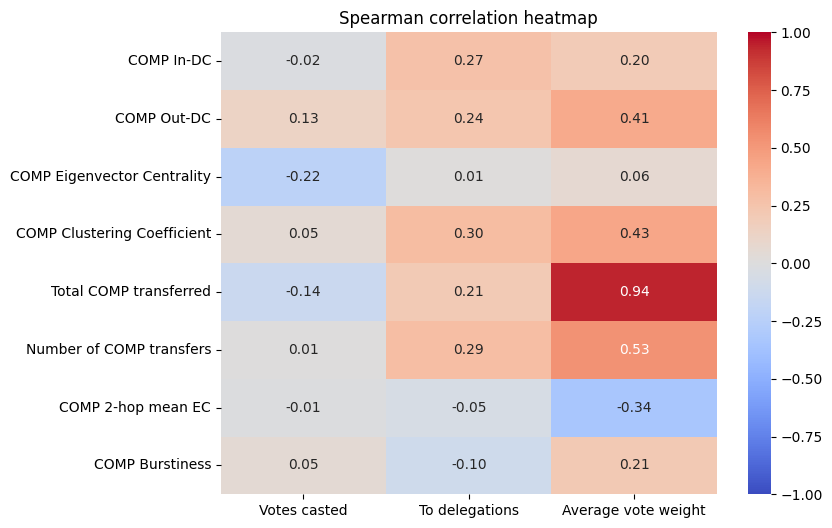

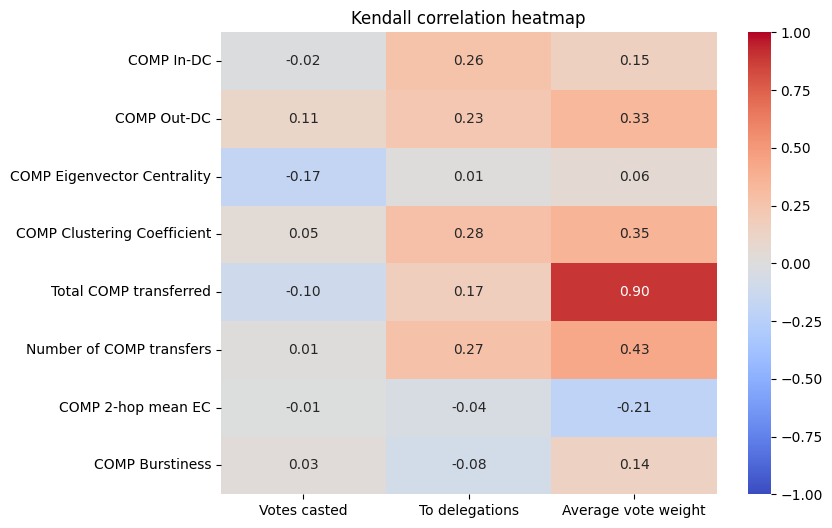

In [ ]:
create_heatmap(comp_gov_results)

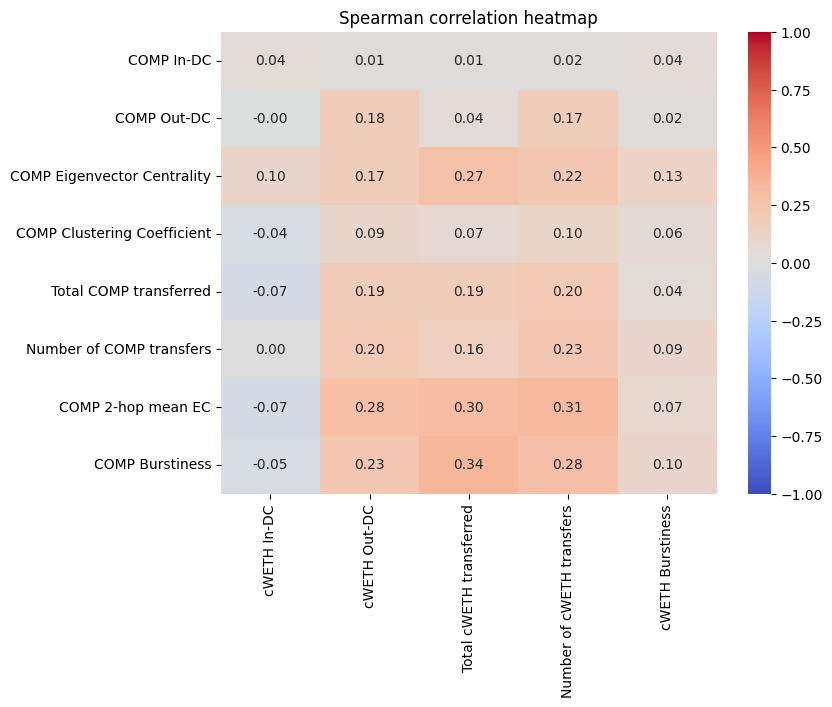

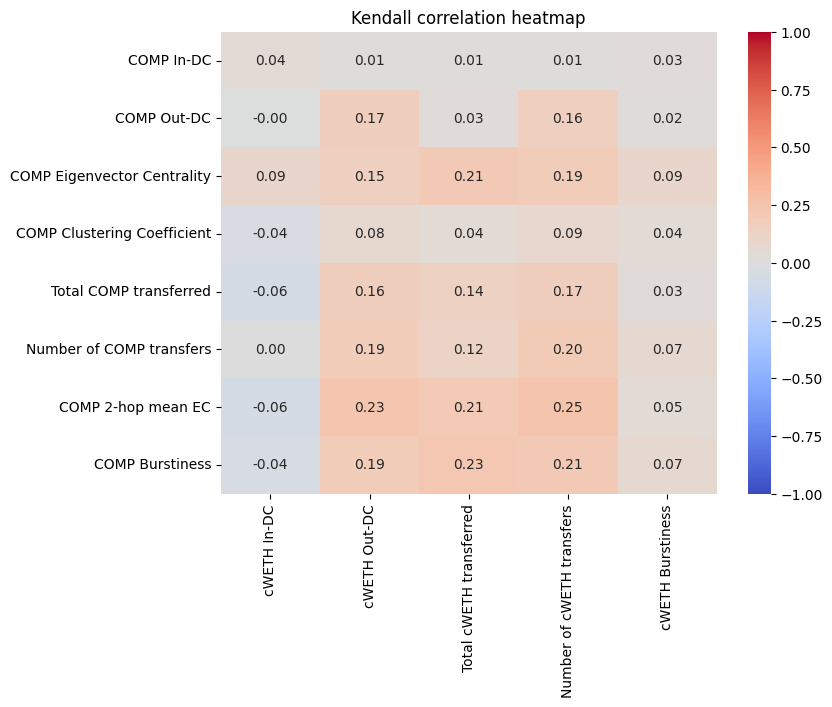

In [41]:
create_heatmap(comp_cWETH_results)

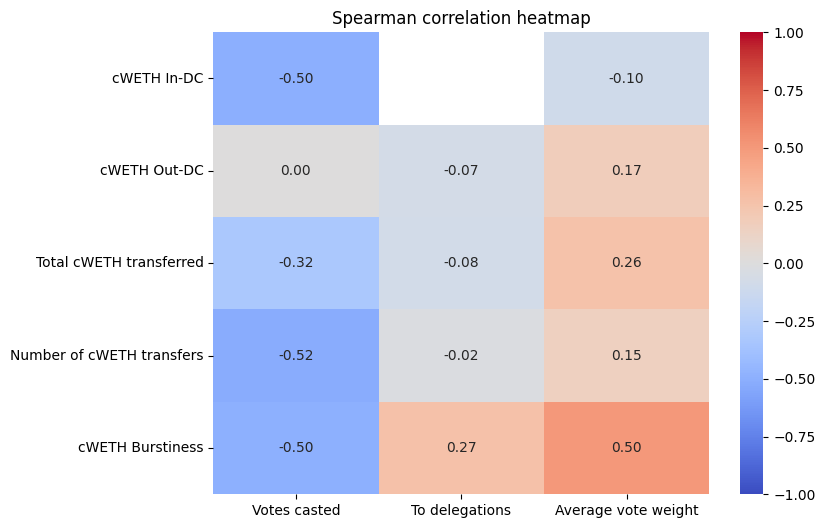

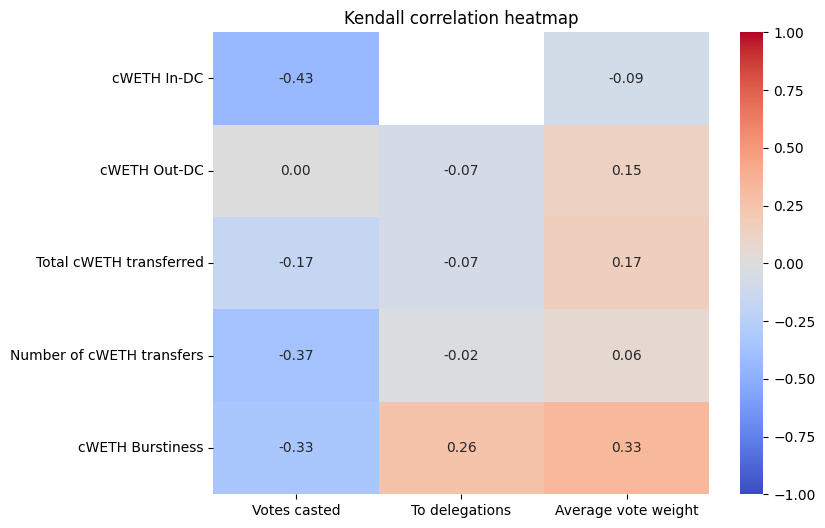

In [42]:
create_heatmap(cWETH_gov_results)

### Subset comparison per feature

In [43]:
cWETH_users_in_COMP = cWETH_users & COMP_users
governance_users_in_COMP = (proposers | voters | delegators) & COMP_users
other_users_in_AAVE = COMP_users - cWETH_users_in_COMP - governance_users_in_COMP

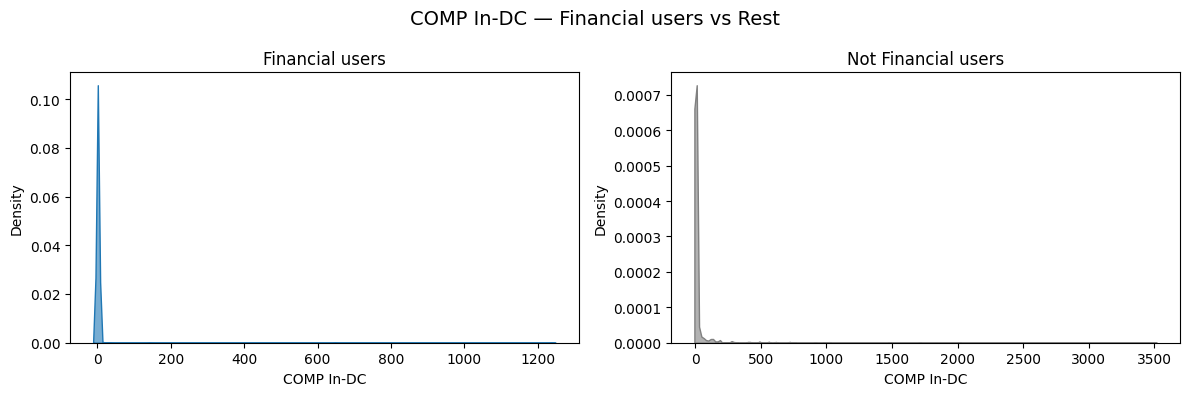

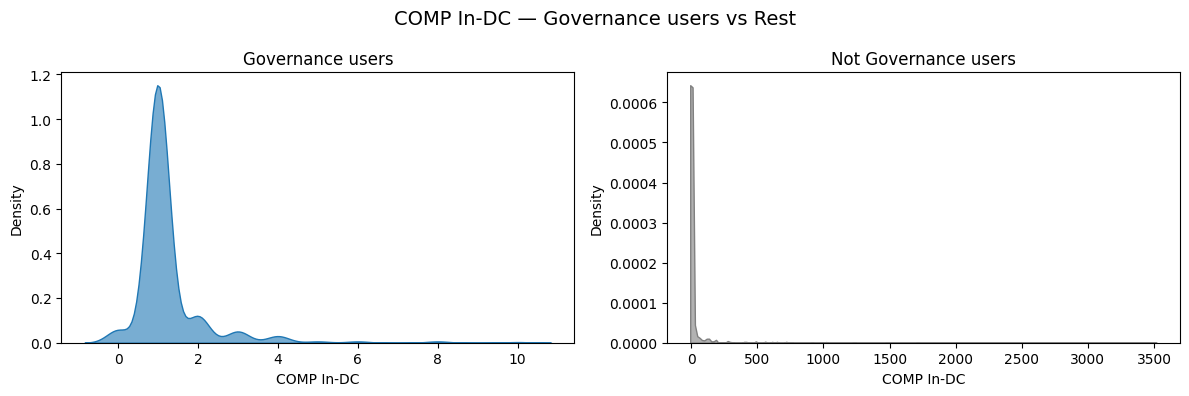

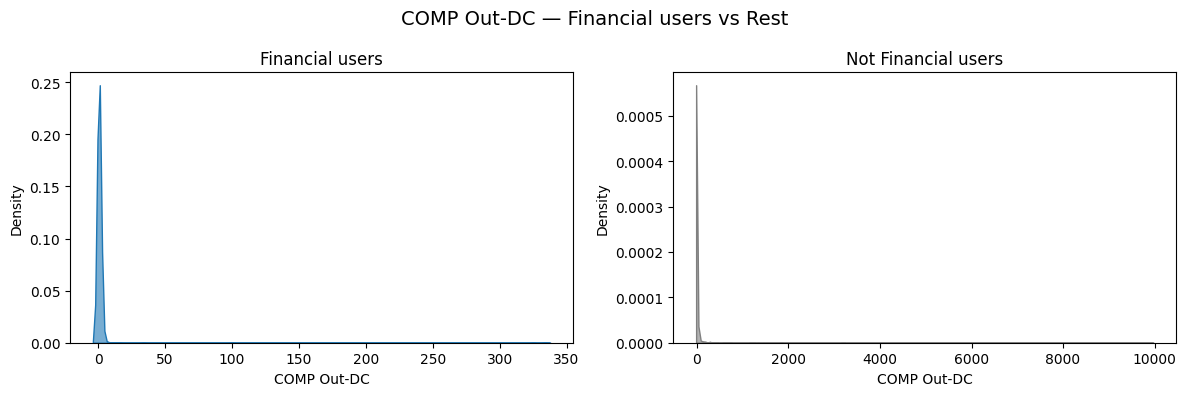

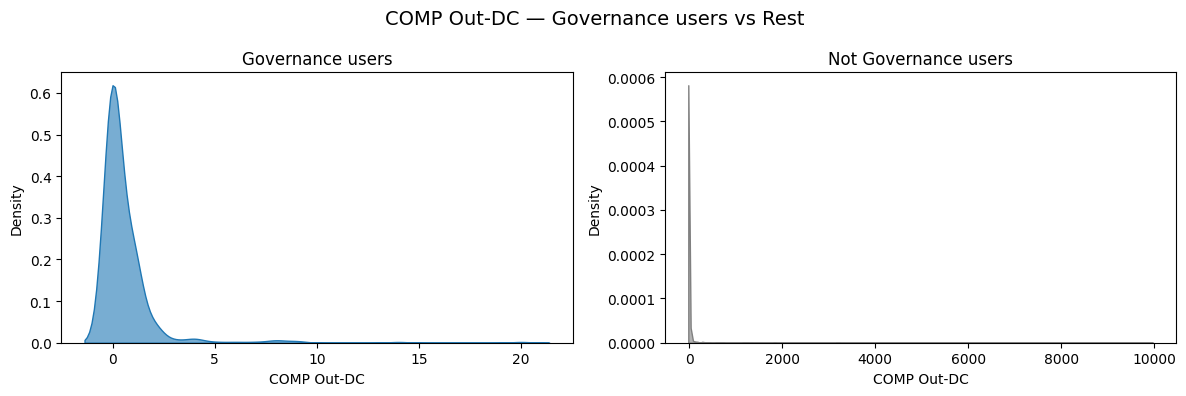

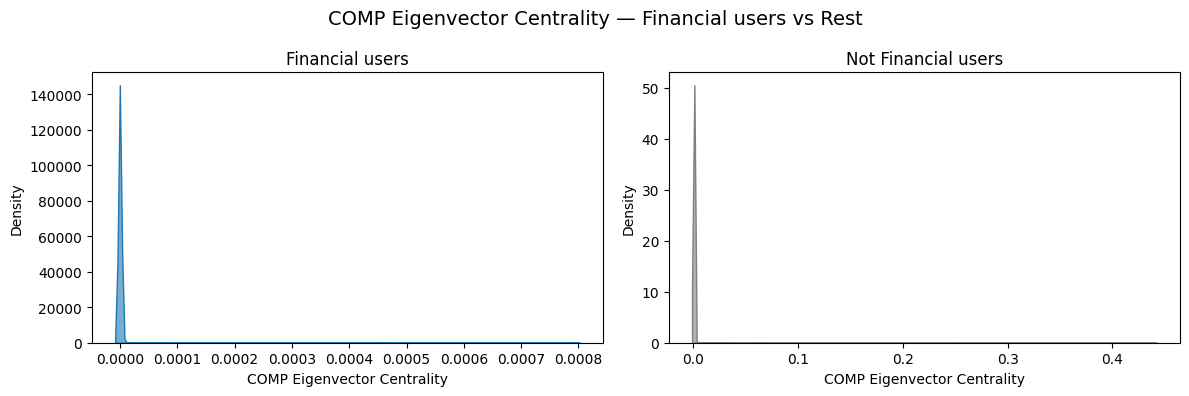

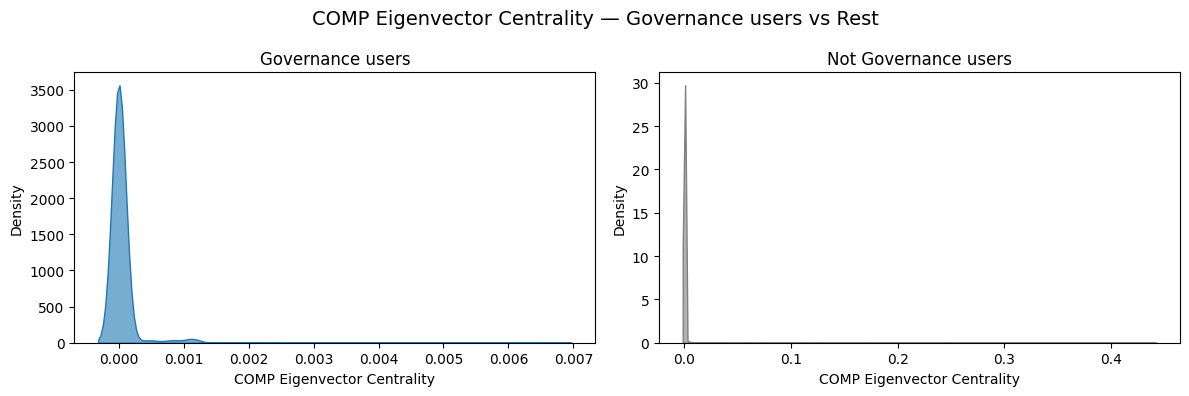

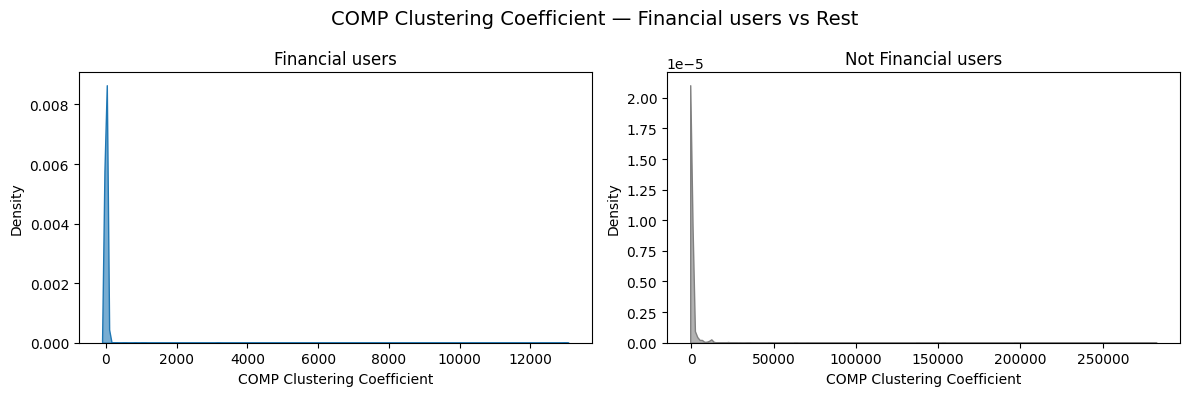

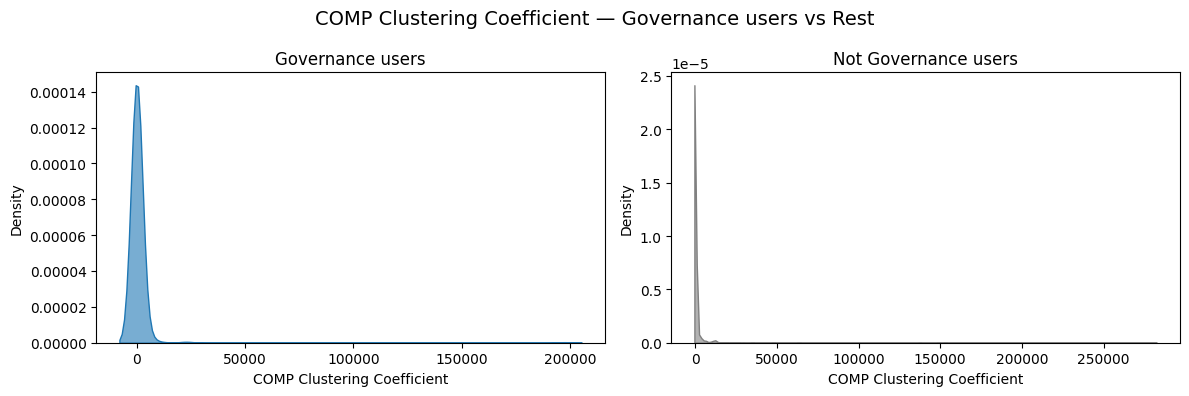

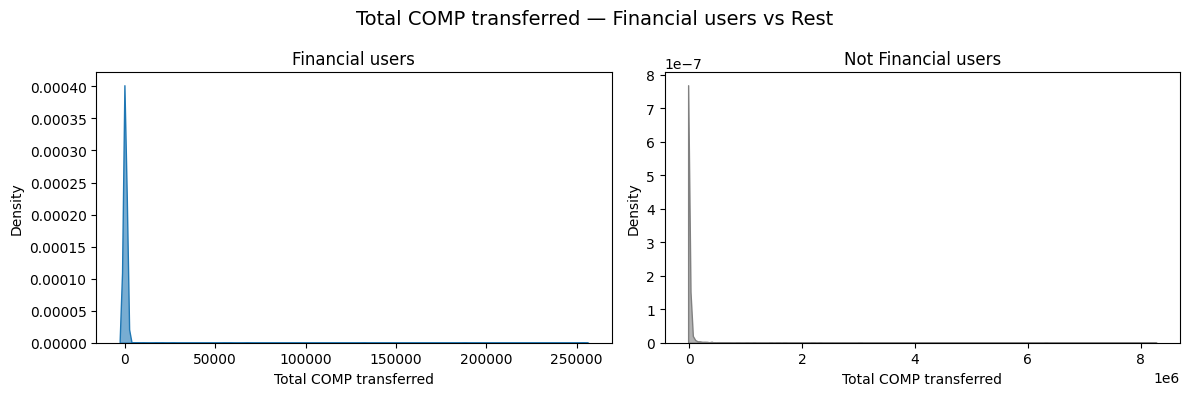

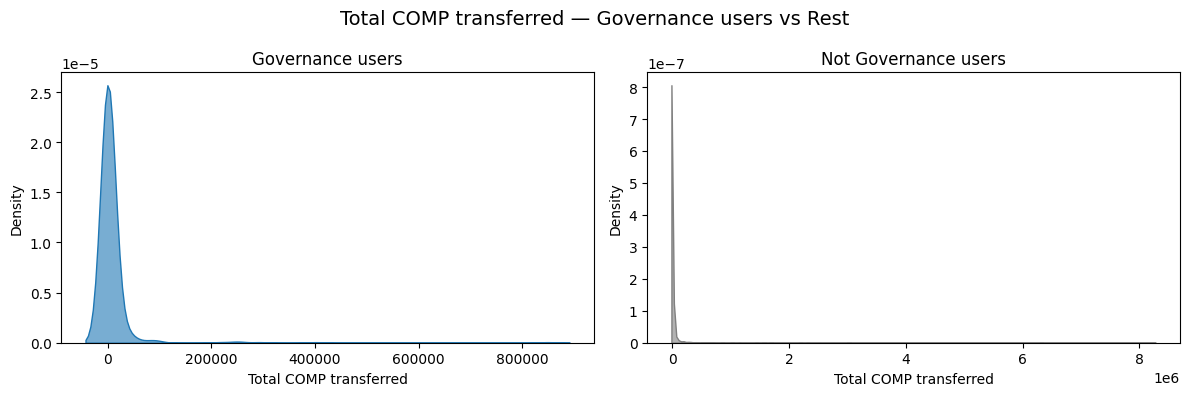

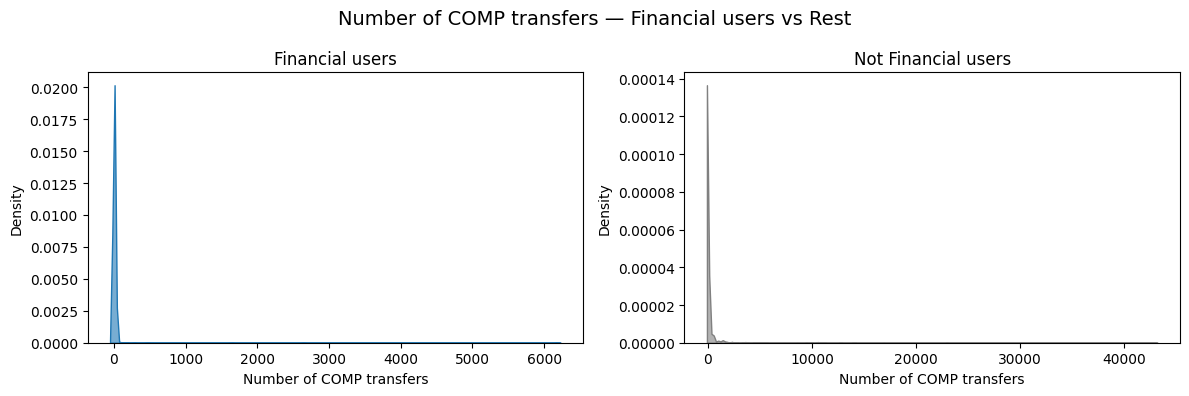

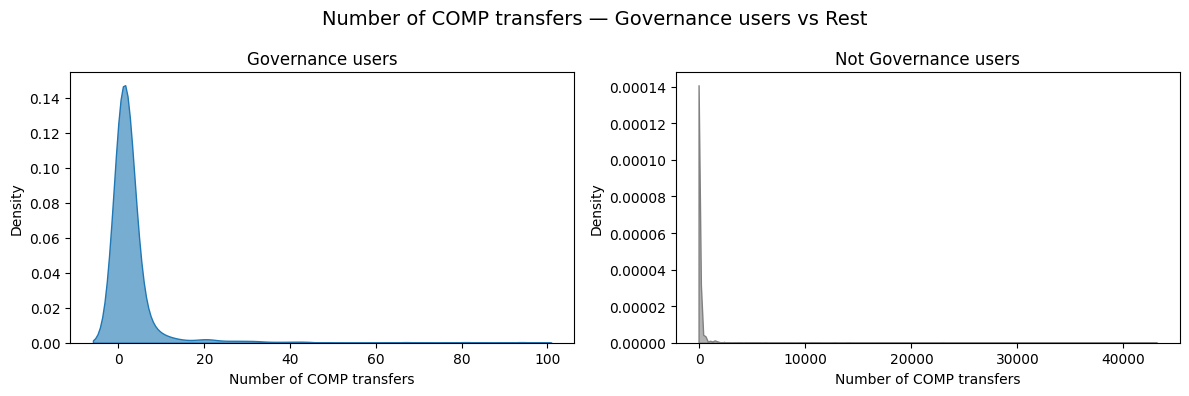

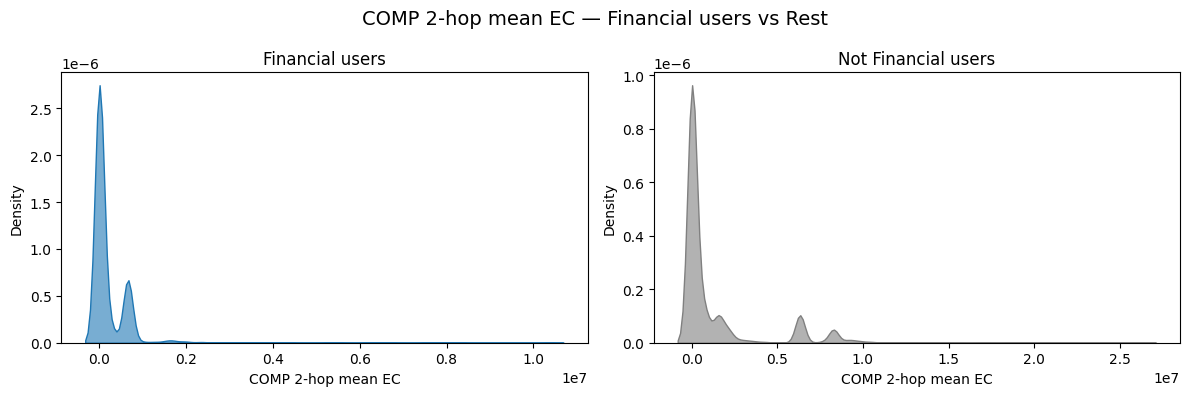

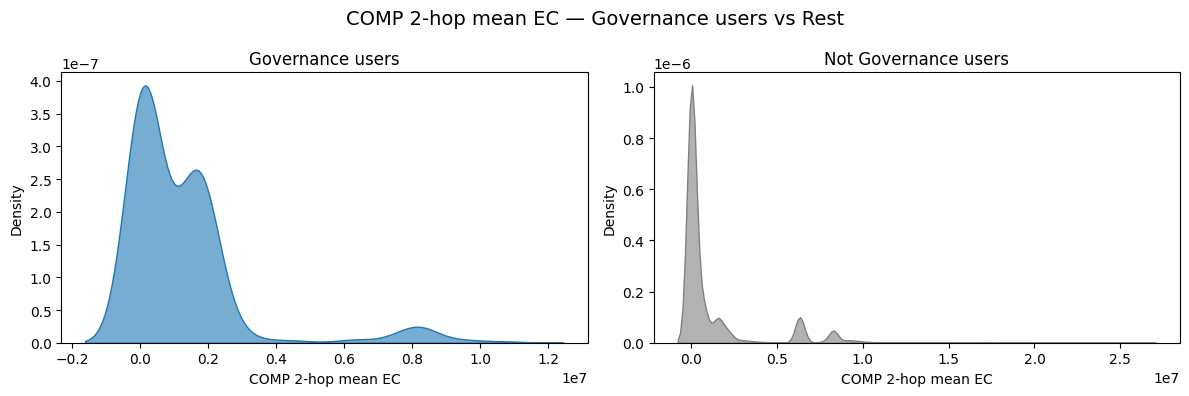

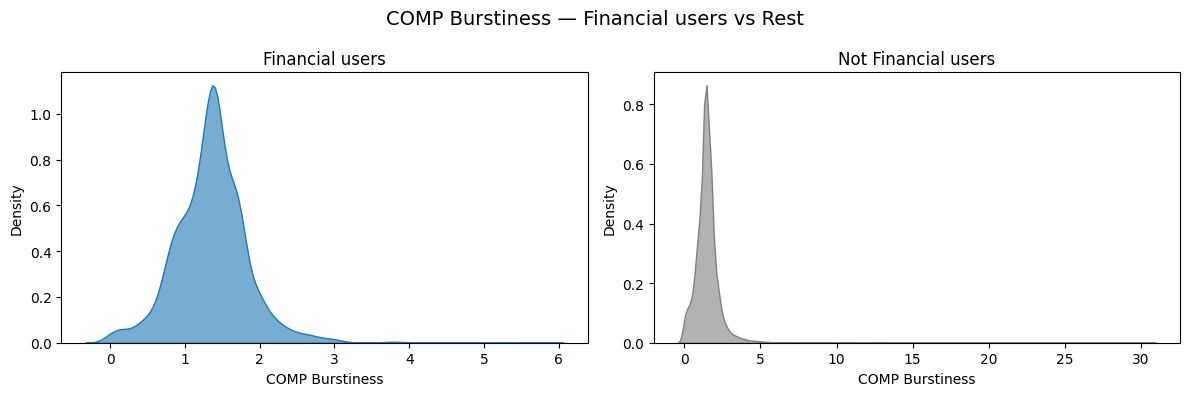

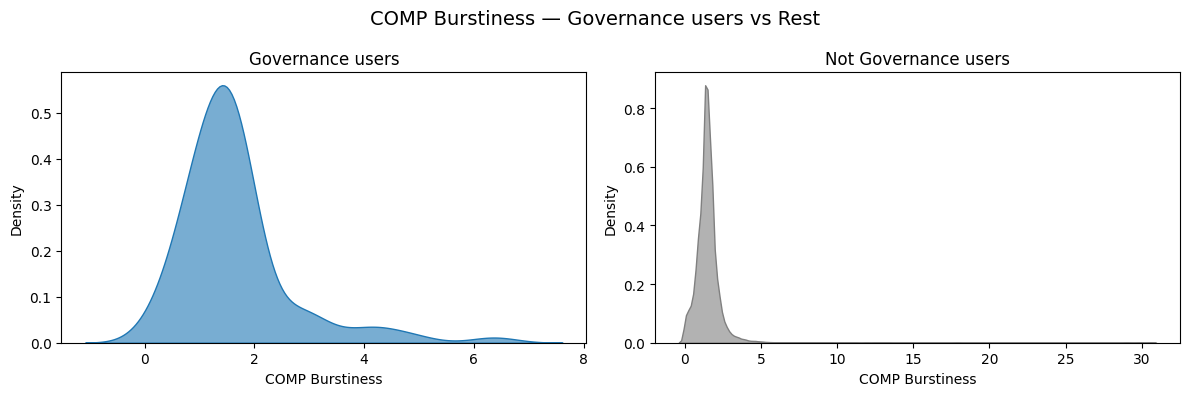

In [44]:
def plot_subset_vs_rest(feature_mapping, feature_name, use_kde=True):
    subsets = {
        'Financial users': cWETH_users_in_COMP,
        'Governance users': governance_users_in_COMP
    }

    for subset_name, subset in subsets.items():
        in_subset = [feature_mapping[node] for node in subset if node in feature_mapping]
        out_subset = [feature_mapping[node] for node in COMP_users - subset if node in feature_mapping]

        fig, axes = plt.subplots(1, 2, figsize=(12, 4))

        if use_kde:
            sns.kdeplot(in_subset, fill=True, alpha=0.6, ax=axes[0])
        else:
            axes[0].hist(in_subset, bins=30, alpha=0.7)
        axes[0].set_title(f'{subset_name}')
        axes[0].set_xlabel(feature_name)
        axes[0].set_ylabel('Density' if use_kde else 'Frequency')

        if use_kde:
            sns.kdeplot(out_subset, fill=True, alpha=0.6, ax=axes[1], color='gray')
        else:
            axes[1].hist(out_subset, bins=30, alpha=0.7, color='gray')
        axes[1].set_title(f'Not {subset_name}')
        axes[1].set_xlabel(feature_name)
        axes[1].set_ylabel('Density' if use_kde else 'Frequency')

        fig.suptitle(f'{feature_name} — {subset_name} vs Rest', fontsize=14)
        plt.tight_layout()
        plt.show()

for feature_name, feature_mapping in COMP_mappings:
    plot_subset_vs_rest(feature_mapping, feature_name, use_kde=True)

## cToken analysis

In [36]:
combined_tokens = {
    'USDC': ['cUSDCv3', 'cArbUSDC'],
    'USDT': ['cUSDTv3', 'cPolUSDT', 'cArbUSDT'],
    'WETH': ['cWETHv3', 'cArbWETH']
}

In [ ]:
transfers_per_token = cToken_df.groupby('token').size()

transfers_per_token = pd.Series({token: transfers_per_token.loc[names].sum() for token, names in combined_tokens.items()})

plt.figure(figsize=(12, 6))
transfers_per_token.plot(kind='bar')
plt.xlabel('Token')
plt.ylabel('Number of transfers')
plt.title('Number of transfers per aToken')
plt.show()

In [ ]:
summed_weights_per_token = cToken_df.groupby('token')['value'].sum()

summed_weights_per_token = pd.Series({token: summed_weights_per_token.loc[names].sum() for token, names in combined_tokens.items()})

plt.figure(figsize=(12, 6))
summed_weights_per_token.plot(kind='bar')
plt.xlabel('Token')
plt.ylabel('Total tokens transferred')
plt.title('Total tokens transferred per token')
plt.show()

In [ ]:
price_data = pd.read_csv('data/WETH_daily_USD.csv', parse_dates=['snapped_at'])

price_data['date'] = pd.to_datetime(price_data['snapped_at']).dt.date
cToken_df['date'] = pd.to_datetime(cToken_df['timestamp'], unit='s')
cToken_df['date'] = cToken_df['date'].dt.date

cToken_df2 = cToken_df.merge(price_data[['date', 'price']], on='date', how='left')

tokens_to_multiply = ['cWETHv3', 'cArbWETH']

cToken_df2['value_traded'] = cToken_df2.apply(
    lambda row: row['value'] * row['price'] if row['token'] in tokens_to_multiply else row['value'], axis=1
)

transfers_over_time_per_token = cToken_df2.groupby('token')['value_traded'].sum()

transfers_over_time_per_token = pd.Series({token: transfers_over_time_per_token.loc[names].sum() for token, names in combined_tokens.items()})

plt.figure(figsize=(12, 6))
transfers_over_time_per_token.plot(kind='bar')
plt.xlabel('Token')
plt.ylabel('Total value traded')
plt.title('Total value traded over time per token')
plt.show()

## Venn diagrams

<Axes: >

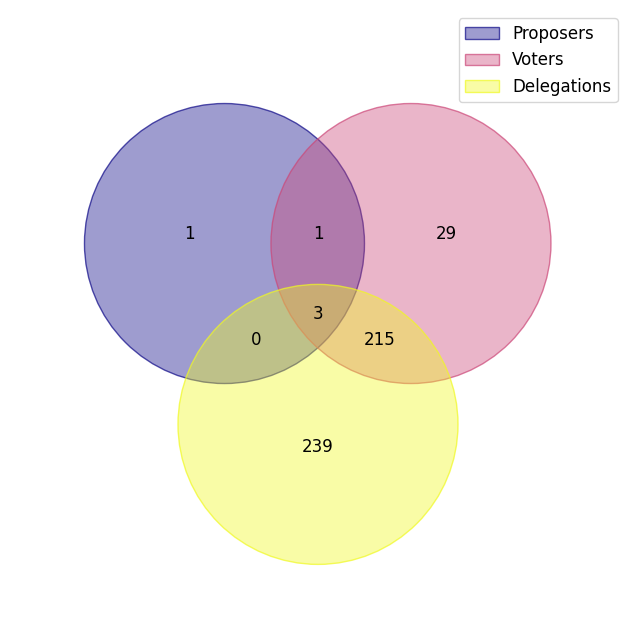

In [38]:
subsets = {
    "Proposers": proposers,
    "Voters": voters,
    "Delegations": all_delegations
}

venn(subsets, fmt="{size}", cmap='plasma', fontsize=12)

<Axes: >

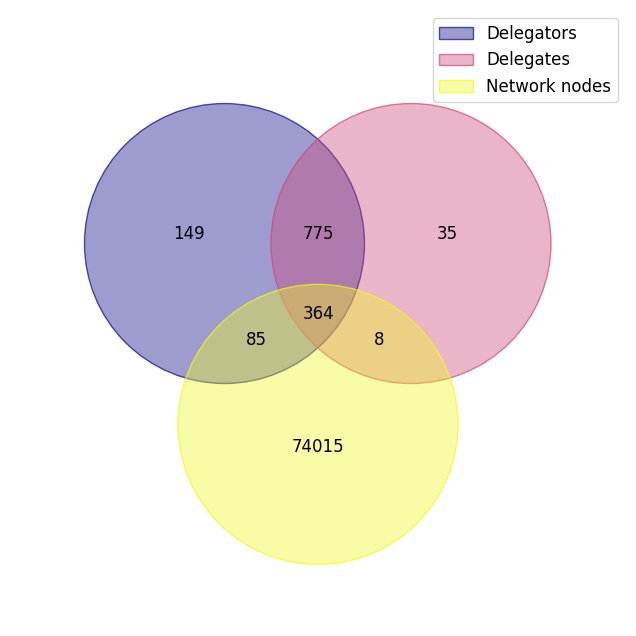

In [39]:
subsets = {
    "Delegators": delegators,
    "Delegates": delegates,
    "Network nodes": set(G_comp_nodes)
}

venn(subsets, fmt="{size}", cmap='plasma', fontsize=12)

<Axes: >

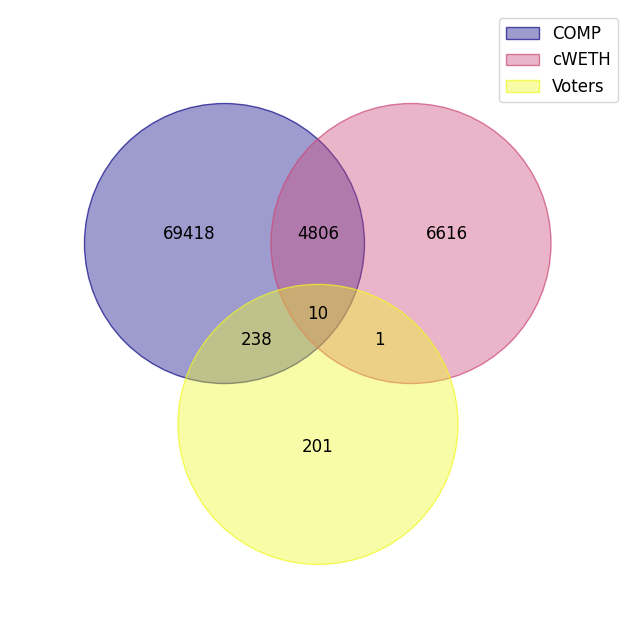

In [43]:
subsets = {
    "COMP": set(G_comp_nodes),
    "cWETH": set(G_cWETH_nodes),
    "Voters": voters
}

venn(subsets, fmt="{size}", cmap='plasma', fontsize=12)

<Axes: >

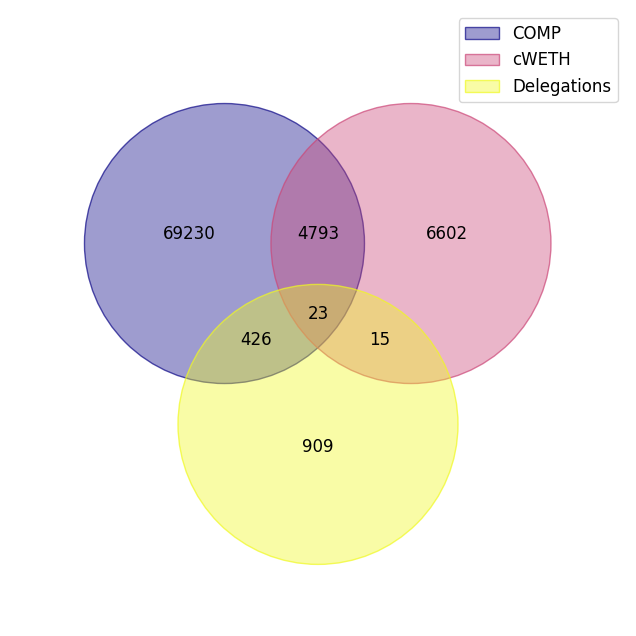

In [44]:
subsets = {
    "COMP": set(G_comp_nodes),
    "cWETH": set(G_cWETH_nodes),
    "Delegations": delegators
}

venn(subsets, fmt="{size}", cmap='plasma', fontsize=12)

<Axes: >

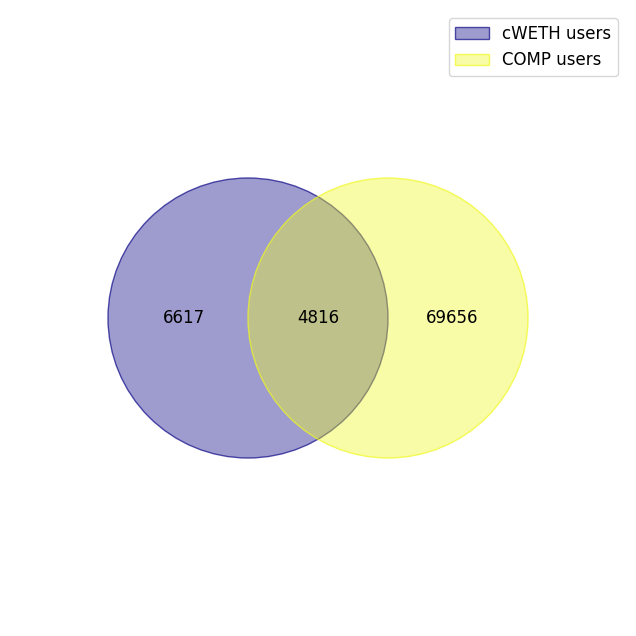

In [6]:
subsets = {
    'cWETH users': cWETH_users,
    'COMP users': COMP_users
}

venn(subsets, fmt="{size}", cmap='plasma', fontsize=12)

## Community detection

### VI, NMI, AMI & ARI

In [47]:
def entropy(labels):
    total = len(labels)
    counts = Counter(labels)
    
    return -sum((count/total) * log2(count/total) for count in counts.values())

def mutual_information(x, y):
    total = len(x)
    counter_x = Counter(x)
    counter_y = Counter(y)
    joint_counter = Counter(zip(x, y))
    mi = 0.0
    
    for (x_val, y_val), joint_count in joint_counter.items():
        px = counter_x[x_val] / total
        py = counter_y[y_val] / total
        pxy = joint_count / total
        mi += pxy * log2(pxy / (px * py))
    
    return mi

def variation_of_information(x, y):
    return entropy(x) + entropy(y) - 2 * mutual_information(x, y)

def run_leiden_iterations(graph, n_iterations=10, resolution=1.0):
    memberships = []
    
    for i in range(n_iterations):
        partition = la.find_partition(
            graph,
            la.ModularityVertexPartition,
            weights='weight',
            # resolution_parameter=resolution,
            # seed=i  # use different seeds for variation
        )
        print(i, partition.modularity)
        
        memberships.append(partition.membership)
    
    return memberships

def compute_vi_nmi_ami_ari(memberships):
    n = len(memberships)
    vi_scores = np.zeros((n, n))
    nmi_scores = np.zeros((n, n))
    ami_scores = np.zeros((n, n))
    ari_scores = np.zeros((n, n))
    
    for i in range(n):
        for j in range(i, n):
            vi = variation_of_information(memberships[i], memberships[j])
            nmi = normalized_mutual_info_score(memberships[i], memberships[j])
            ami = adjusted_mutual_info_score(memberships[i], memberships[j])
            ari = adjusted_rand_score(memberships[i], memberships[j])
            
            vi_scores[i, j] = vi_scores[j, i] = vi
            nmi_scores[i, j] = nmi_scores[j, i] = nmi
            ami_scores[i, j] = ami_scores[j, i] = ami
            ari_scores[i, j] = ari_scores[j, i] = ari
    return vi_scores, nmi_scores, ami_scores, ari_scores

In [45]:
G_comp_count_igraph = ig.Graph.from_networkx(G_comp_count, vertex_attr_hashable='name')
G_comp_count_igraph_components = G_comp_count_igraph.connected_components(mode="weak")
G_comp_count_igraph_largest_wcc = G_comp_count_igraph_components.giant()

In [48]:
n_iterations = 10
resolution = 1.0
memberships = run_leiden_iterations(G_comp_count_igraph_largest_wcc, n_iterations, resolution)

vi_scores, nmi_scores, ami_scores, ari_scores = compute_vi_nmi_ami_ari(memberships)

avg_vi = np.mean(vi_scores[np.triu_indices(n_iterations, k=1)])
avg_nmi = np.mean(nmi_scores[np.triu_indices(n_iterations, k=1)])
avg_ami = np.mean(ami_scores[np.triu_indices(n_iterations, k=1)])
avg_ari = np.mean(ari_scores[np.triu_indices(n_iterations, k=1)])

print(f"Average VI: {avg_vi:.4f}")
print(f"Average NMI: {avg_nmi:.4f}")
print(f"Average AMI: {avg_ami:.4f}")
print(f"Average ARI: {avg_ari:.4f}")

0 0.7273293111872682
1 0.7252661465522726
2 0.7251481215376394
3 0.7251481215376394
4 0.724736030044662
5 0.7313331077500861
6 0.7247940173314308
7 0.7247940173314308
8 0.7263391403470051
9 0.7272331271252539
Average VI: 0.1971
Average NMI: 0.9729
Average AMI: 0.9726
Average ARI: 0.9754


In [49]:
G_comp_igraph = ig.Graph.from_networkx(G_comp, vertex_attr_hashable='name')
G_comp_igraph_components = G_comp_igraph.connected_components(mode="weak")
G_comp_igraph_largest_wcc = G_comp_igraph_components.giant()

In [50]:
n_iterations = 10
resolution = 1.0
memberships = run_leiden_iterations(G_comp_igraph_largest_wcc, n_iterations, resolution)

vi_scores, nmi_scores, ami_scores, ari_scores = compute_vi_nmi_ami_ari(memberships)

avg_vi = np.mean(vi_scores[np.triu_indices(n_iterations, k=1)])
avg_nmi = np.mean(nmi_scores[np.triu_indices(n_iterations, k=1)])
avg_ami = np.mean(ami_scores[np.triu_indices(n_iterations, k=1)])
avg_ari = np.mean(ari_scores[np.triu_indices(n_iterations, k=1)])

print(f"Average VI: {avg_vi:.4f}")
print(f"Average NMI: {avg_nmi:.4f}")
print(f"Average AMI: {avg_ami:.4f}")
print(f"Average ARI: {avg_ari:.4f}")

0 0.618404193384544
1 0.6184831199777002
2 0.6184993435311787
3 0.6181661190756162
4 0.6182779700680652
5 0.6182779700680652
6 0.6183157923500352
7 0.6179157348872389
8 0.6179157348872389
9 0.6187307062773362
Average VI: 0.1836
Average NMI: 0.9711
Average AMI: 0.9708
Average ARI: 0.9908


In [51]:
n_iterations = 10
resolution = 1.0
memberships = run_leiden_iterations(G_comp_count_igraph, n_iterations, resolution)

vi_scores, nmi_scores, ami_scores, ari_scores = compute_vi_nmi_ami_ari(memberships)

avg_vi = np.mean(vi_scores[np.triu_indices(n_iterations, k=1)])
avg_nmi = np.mean(nmi_scores[np.triu_indices(n_iterations, k=1)])
avg_ami = np.mean(ami_scores[np.triu_indices(n_iterations, k=1)])
avg_ari = np.mean(ari_scores[np.triu_indices(n_iterations, k=1)])

print(f"Average VI: {avg_vi:.4f}")
print(f"Average NMI: {avg_nmi:.4f}")
print(f"Average AMI: {avg_ami:.4f}")
print(f"Average ARI: {avg_ari:.4f}")

0 0.7371054893722433
1 0.7373231413217255
2 0.7355894027422358
3 0.7355894027422358
4 0.7354879503270054
5 0.7432902299462982
6 0.7373353945476762
7 0.7357017431172111
8 0.7343034359970644
9 0.7357181228145527
Average VI: 0.2648
Average NMI: 0.9714
Average AMI: 0.9679
Average ARI: 0.9629


In [52]:
n_iterations = 10
resolution = 1.0
memberships = run_leiden_iterations(G_comp_igraph, n_iterations, resolution)

vi_scores, nmi_scores, ami_scores, ari_scores = compute_vi_nmi_ami_ari(memberships)

avg_vi = np.mean(vi_scores[np.triu_indices(n_iterations, k=1)])
avg_nmi = np.mean(nmi_scores[np.triu_indices(n_iterations, k=1)])
avg_ami = np.mean(ami_scores[np.triu_indices(n_iterations, k=1)])
avg_ari = np.mean(ari_scores[np.triu_indices(n_iterations, k=1)])

print(f"Average VI: {avg_vi:.4f}")
print(f"Average NMI: {avg_nmi:.4f}")
print(f"Average AMI: {avg_ami:.4f}")
print(f"Average ARI: {avg_ari:.4f}")

0 0.6355107456316625
1 0.6355107456316625
2 0.6344537058846424
3 0.6346839443077208
4 0.634904073903175
5 0.6365048142508073
6 0.6350155356963059
7 0.6354697665169626
8 0.6346947830161742
9 0.6356051460050602
Average VI: 0.2132
Average NMI: 0.9749
Average AMI: 0.9718
Average ARI: 0.9877


### Regular Leiden

#### Applied on G_comp_count

##### Basic analysis

In [53]:
G_comp_count_igraph = ig.Graph.from_networkx(G_comp_count, vertex_attr_hashable='name')
# G_comp_count_igraph = ig.Graph.from_networkx(G_comp, vertex_attr_hashable='name')

G_comp_count_igraph_components = G_comp_count_igraph.connected_components(mode="weak")
G_comp_count_igraph_largest_wcc = G_comp_count_igraph_components.giant()

partition = la.find_partition(G_comp_count_igraph_largest_wcc, la.ModularityVertexPartition, weights='weight')

print(len(partition), partition.modularity)

117 0.7260653121254841


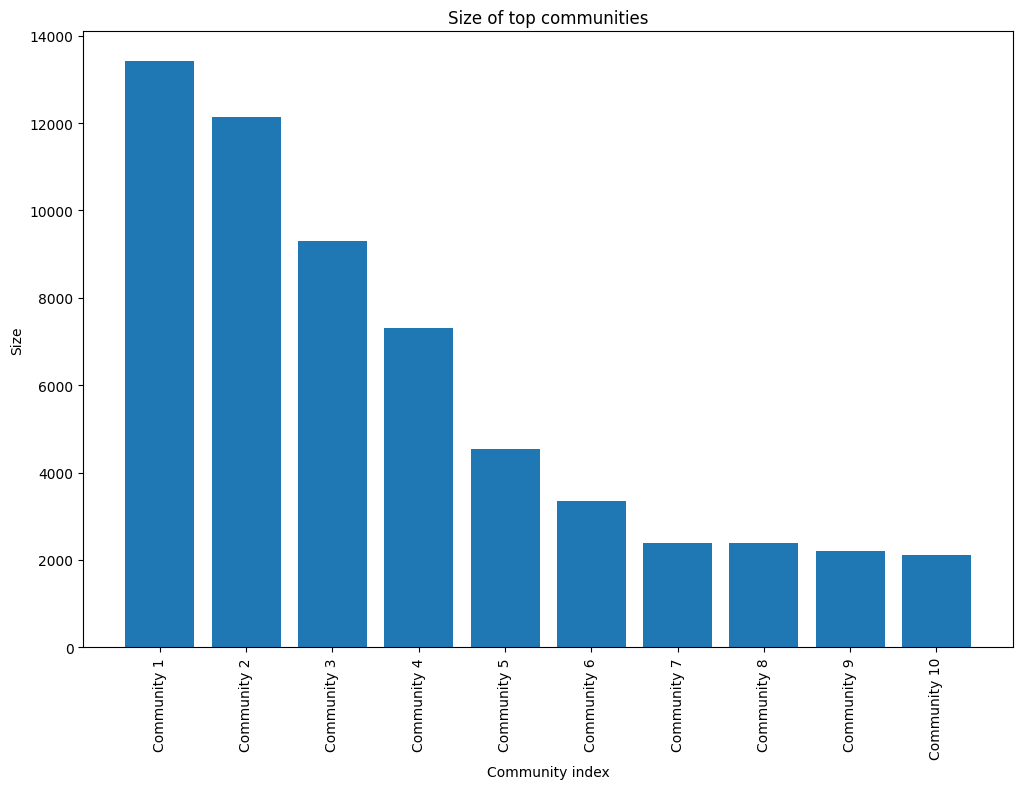

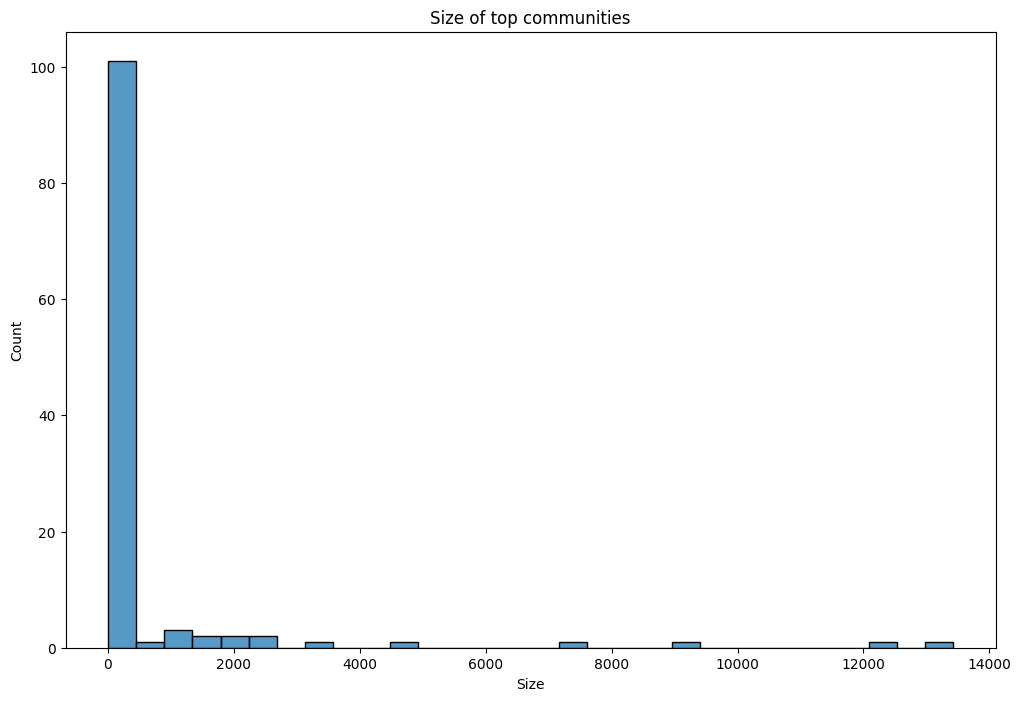

In [54]:
community_sizes = [len(c) for c in partition]

sorted_indices = sorted(range(len(community_sizes)), key=lambda i: community_sizes[i], reverse=True)

sorted_communities = [partition[i] for i in sorted_indices]

top_communities = sorted_communities[:10]

top_communities_sizes = [len(community) for community in top_communities]

plt.figure(figsize=(12, 8))
plt.bar(range(len(top_communities)), top_communities_sizes)
plt.xlabel('Community index')
plt.ylabel('Size')
plt.title('Size of top communities')
plt.xticks(range(len(top_communities)), [f'Community {i+1}' for i in range(len(top_communities))], rotation=90)
plt.show()

all_communities_sizes = [len(community) for community in sorted_communities]
log_bins = np.logspace(np.log10(min(all_communities_sizes)), np.log10(max(all_communities_sizes)), 30)

plt.figure(figsize=(12, 8))
sns.histplot(all_communities_sizes, bins=30)
# plt.yscale('log')
# sns.histplot(all_communities_sizes, bins=log_bins)
# plt.xscale('log')
plt.xlabel('Size')
plt.ylabel('Count')
plt.title('Size of top communities')
plt.show()

In [57]:
community_distribution = {
    'Economic': [],
    'Governance': [],
    'Both': [],
    'None': []
}

only_economic_users_in_G_wcc = only_economic_users_in_G_comp & set(G_comp_count_igraph_largest_wcc.vs["name"])
only_voters_in_G_wcc = only_voters_in_G_comp & set(G_comp_count_igraph_largest_wcc.vs["name"])
both_economic_and_governance_users_in_G_wcc = both_economic_and_governance_users & set(G_comp_count_igraph_largest_wcc.vs["name"])
all_economic_users_in_G_wcc = all_economic_users_in_G_comp & set(G_comp_count_igraph_largest_wcc.vs["name"])
all_voters_in_G_wcc = all_voters_in_G_comp & set(G_comp_count_igraph_largest_wcc.vs["name"])

communities_with_ids = [
    {G_comp_count_igraph_largest_wcc.vs[idx]["name"] for idx in community} for community in top_communities
]

total_economic_percentage = 0
total_governance_percentage = 0

economic_percentages = []
governance_percentages = []

id = 1
for community in communities_with_ids:
    economic_count = len(only_economic_users_in_G_wcc & community)
    governance_count = len(only_voters_in_G_wcc & community)
    both_count = len(both_economic_and_governance_users_in_G_wcc & community)
    none_count = len(community) - economic_count - governance_count - both_count
    
    # total_count = economic_count + voter_count + both_count + none_count
    
    # percentage = ((economic_count + voter_count + both_count) / total_count)*100
    
    economic_count_2 = len(all_economic_users_in_G_wcc & community)
    governance_count_2 = len(all_voters_in_G_wcc & community)
    
    economic_percentage = (economic_count_2 / len(all_economic_users_in_G_wcc)) * 100
    governance_percentage = (governance_count_2 / len(all_voters_in_G_wcc)) * 100
    
    economic_percentages.append(economic_percentage)
    governance_percentages.append(governance_percentage)
    
    total_economic_percentage += economic_percentage
    total_governance_percentage += governance_percentage
    
    print(f'Percentage of all the users in community {id}, economic: {economic_percentage:.0f}%, governance: {governance_percentage:.0f}%')
    
    id += 1
    
    community_distribution['Economic'].append(economic_count)
    community_distribution['Governance'].append(governance_count)
    community_distribution['Both'].append(both_count)
    community_distribution['None'].append(none_count)

print(f'{total_economic_percentage:.1f}%, {total_governance_percentage:.1f}%')

Percentage of all the users in community 1, economic: 78%, governance: 4%
Percentage of all the users in community 2, economic: 0%, governance: 25%
Percentage of all the users in community 3, economic: 0%, governance: 1%
Percentage of all the users in community 4, economic: 1%, governance: 2%
Percentage of all the users in community 5, economic: 0%, governance: 62%
Percentage of all the users in community 6, economic: 12%, governance: 1%
Percentage of all the users in community 7, economic: 5%, governance: 2%
Percentage of all the users in community 8, economic: 0%, governance: 2%
Percentage of all the users in community 9, economic: 0%, governance: 0%
Percentage of all the users in community 10, economic: 1%, governance: 0%
99.0%, 99.2%


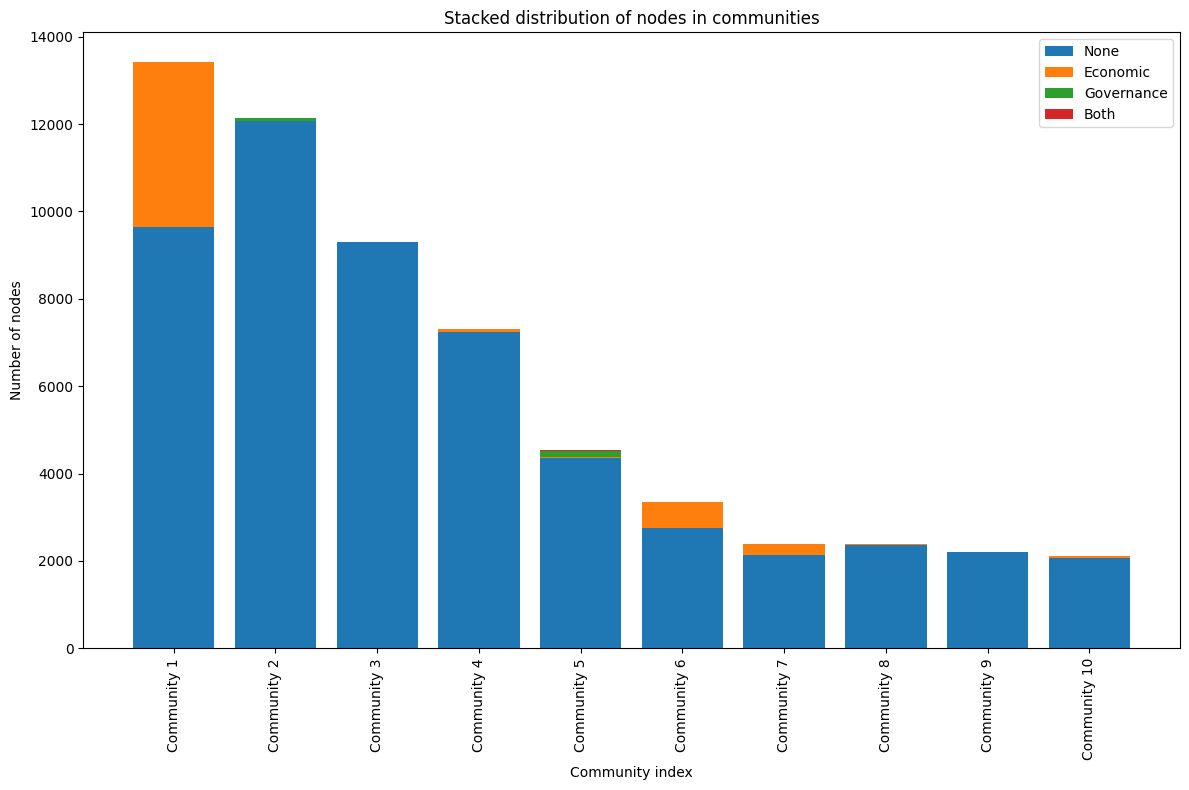

In [58]:
fig, ax = plt.subplots(1, 1, figsize=(12, 8))

bar_width = 0.8
index = np.arange(len(communities_with_ids))

economic_array = np.array(community_distribution['Economic'])
governance_array = np.array(community_distribution['Governance'])
both_array = np.array(community_distribution['Both'])
none_array = np.array(community_distribution['None'])

bar1 = ax.bar(index, none_array, bar_width, label='None')
bar2 = ax.bar(index, economic_array, bar_width, bottom=none_array, label='Economic')
bar3 = ax.bar(index, governance_array, bar_width, bottom=none_array + economic_array, label='Governance')
bar4 = ax.bar(index, both_array, bar_width, bottom=none_array + economic_array + governance_array, label='Both')

ax.set_xlabel('Community index')
ax.set_ylabel('Number of nodes')
ax.set_title('Stacked distribution of nodes in communities')
ax.set_xticks(index)
ax.set_xticklabels([f'Community {i+1}' for i in range(len(communities_with_ids))], rotation=90)
ax.legend()

plt.tight_layout()
plt.show()

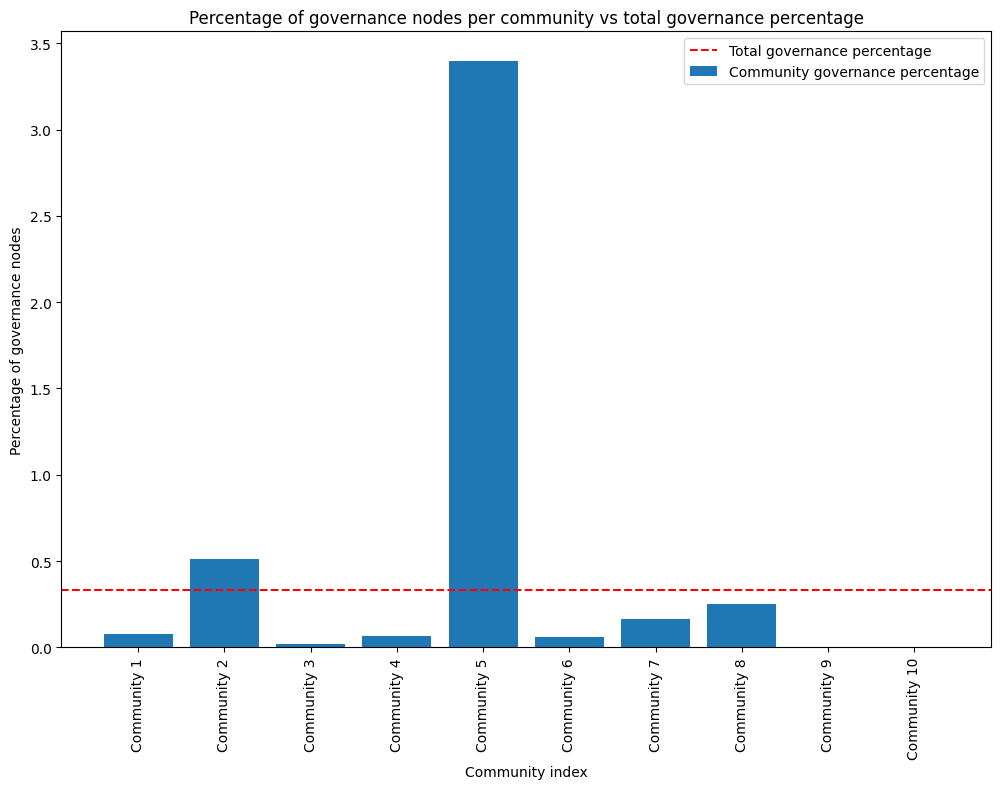

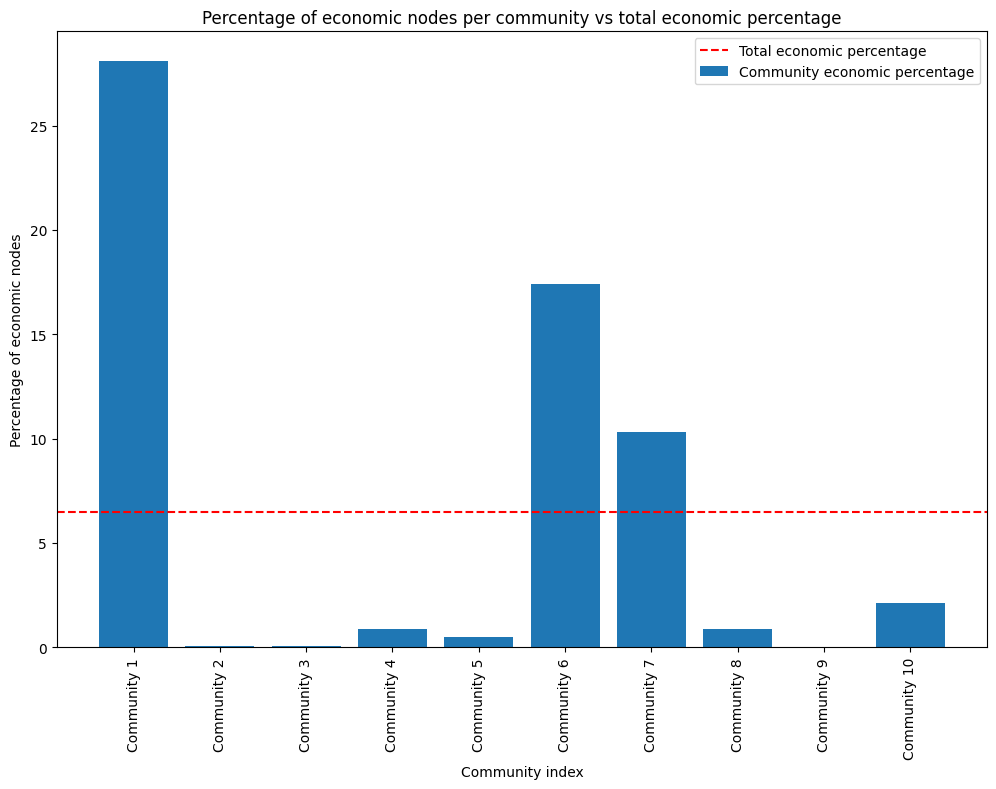

In [59]:
total_governance_percentage = (len(all_voters_in_G_comp) / len(G_comp_nodes)) * 100
total_economic_percentage = (len(all_economic_users_in_G_comp) / len(G_comp_nodes)) * 100

community_governance_percentages = []
community_economic_percentages = []
for community in communities_with_ids:
    governance_count = len(community & all_voters_in_G_comp)
    community_percentage = (governance_count / len(community)) * 100
    community_governance_percentages.append(community_percentage)
    
    economic_count = len(community & all_economic_users_in_G_comp)
    economic_percentage = (economic_count / len(community)) * 100
    community_economic_percentages.append(economic_percentage)

plt.figure(figsize=(12, 8))
plt.bar(range(len(top_communities)), community_governance_percentages, label='Community governance percentage')
plt.axhline(y=total_governance_percentage, color='r', linestyle='--', label='Total governance percentage')
plt.xlabel('Community index')
plt.ylabel('Percentage of governance nodes')
plt.title('Percentage of governance nodes per community vs total governance percentage')
plt.legend()
plt.xticks(range(len(top_communities)), [f'Community {i+1}' for i in range(len(top_communities))], rotation=90)
plt.show()

plt.figure(figsize=(12, 8))
plt.bar(range(len(top_communities)), community_economic_percentages, label='Community economic percentage')
plt.axhline(y=total_economic_percentage, color='r', linestyle='--', label='Total economic percentage')
plt.xlabel('Community index')
plt.ylabel('Percentage of economic nodes')
plt.title('Percentage of economic nodes per community vs total economic percentage')
plt.legend()
plt.xticks(range(len(top_communities)), [f'Community {i+1}' for i in range(len(top_communities))], rotation=90)
plt.show()

##### Feature averages per community

In [60]:
def plot_per_community(mapping):
    community_averages = {feature_name: [] for feature_name, _ in mapping}
    community_distributions = {feature_name: [] for feature_name, _ in mapping}

    for community in top_communities:
        community_node_ids = {G_comp_count_igraph_largest_wcc.vs[idx]["name"] for idx in community}

        for feature_name, feature_mapping in mapping:
            feature_values = [feature_mapping[node_id] for node_id in community_node_ids if node_id in feature_mapping]
            average_value = sum(feature_values) / len(feature_values) if feature_values else 0
            
            community_averages[feature_name].append(average_value)
            community_distributions[feature_name].append(feature_values)

    # for feature_name, averages in community_averages.items():
    #     plt.figure(figsize=(12, 8))
    #     plt.plot(range(len(top_communities)), averages, marker='o', label=feature_name)
    #     plt.xlabel('Community')
    #     plt.ylabel('Average feature value')
    #     plt.title(feature_name)
    #     # plt.legend()
    #     # plt.grid()
    #     plt.show()
    
    num_features = len(mapping)
    cols = 3
    rows = (num_features + cols - 1) // cols
    
    fig, axs = plt.subplots(rows, cols, figsize=(15, 4 * rows))
    axs = axs.flatten()
    
    for i, (feature_name, averages) in enumerate(community_averages.items()):
        axs[i].plot(range(len(top_communities)), averages, marker='o')
        axs[i].set_title(feature_name)
        # axs[i].grid(True)
    
    for j in range(i + 1, len(axs)):
        axs[j].axis('off')
    
    plt.tight_layout()
    plt.show()
    
    # fig, axs = plt.subplots(rows, cols, figsize=(15, 4 * rows))
    # axs = axs.flatten()

    # for i, (feature_name, distributions) in enumerate(community_distributions.items()):
    #     axs[i].boxplot(distributions, tick_labels=[f'C{j}' for j in range(len(distributions))])
    #     axs[i].set_title(f'{feature_name} distribution per community')
    #     axs[i].set_xlabel('Community')
    #     axs[i].set_ylabel('Feature Value')
    #     # axs[i].grid(True)

    # for j in range(i + 1, len(axs)):
    #     axs[j].axis('off')

    plt.tight_layout()
    plt.show()

In [61]:
def plot_per_community_2(mapping):
    # Compute global stats for each feature
    feature_stats = {}
    for feature_name, feature_mapping in mapping:
        values = list(feature_mapping.values())
        mean = np.mean(values)
        std = np.std(values)
        feature_stats[feature_name] = (mean, std)

    # Initialize containers
    community_averages = {feature_name: [] for feature_name, _ in mapping}
    community_distributions = {feature_name: [] for feature_name, _ in mapping}

    for community in top_communities:
        community_node_ids = {G_comp_count_igraph_largest_wcc.vs[idx]["name"] for idx in community}

        for feature_name, feature_mapping in mapping:
            feature_values = [feature_mapping[node_id] for node_id in community_node_ids if node_id in feature_mapping]

            if feature_values:
                avg_val = sum(feature_values) / len(feature_values)
                mean, std = feature_stats[feature_name]
                z_score = (avg_val - mean) / std if std > 0 else 0
            else:
                z_score = 0

            community_averages[feature_name].append(z_score)
            community_distributions[feature_name].append(feature_values)

    # Plot normalized community averages
    num_features = len(mapping)
    cols = 3
    rows = (num_features + cols - 1) // cols

    fig, axs = plt.subplots(rows, cols, figsize=(15, 4 * rows))
    axs = axs.flatten()

    for i, (feature_name, averages) in enumerate(community_averages.items()):
        axs[i].plot(range(len(top_communities)), averages, marker='o')
        axs[i].set_title(f'{feature_name} (z-score)')
        axs[i].set_xlabel('Community')
        axs[i].set_ylabel('Z-score')

    for j in range(i + 1, len(axs)):
        axs[j].axis('off')

    plt.tight_layout()
    plt.show()

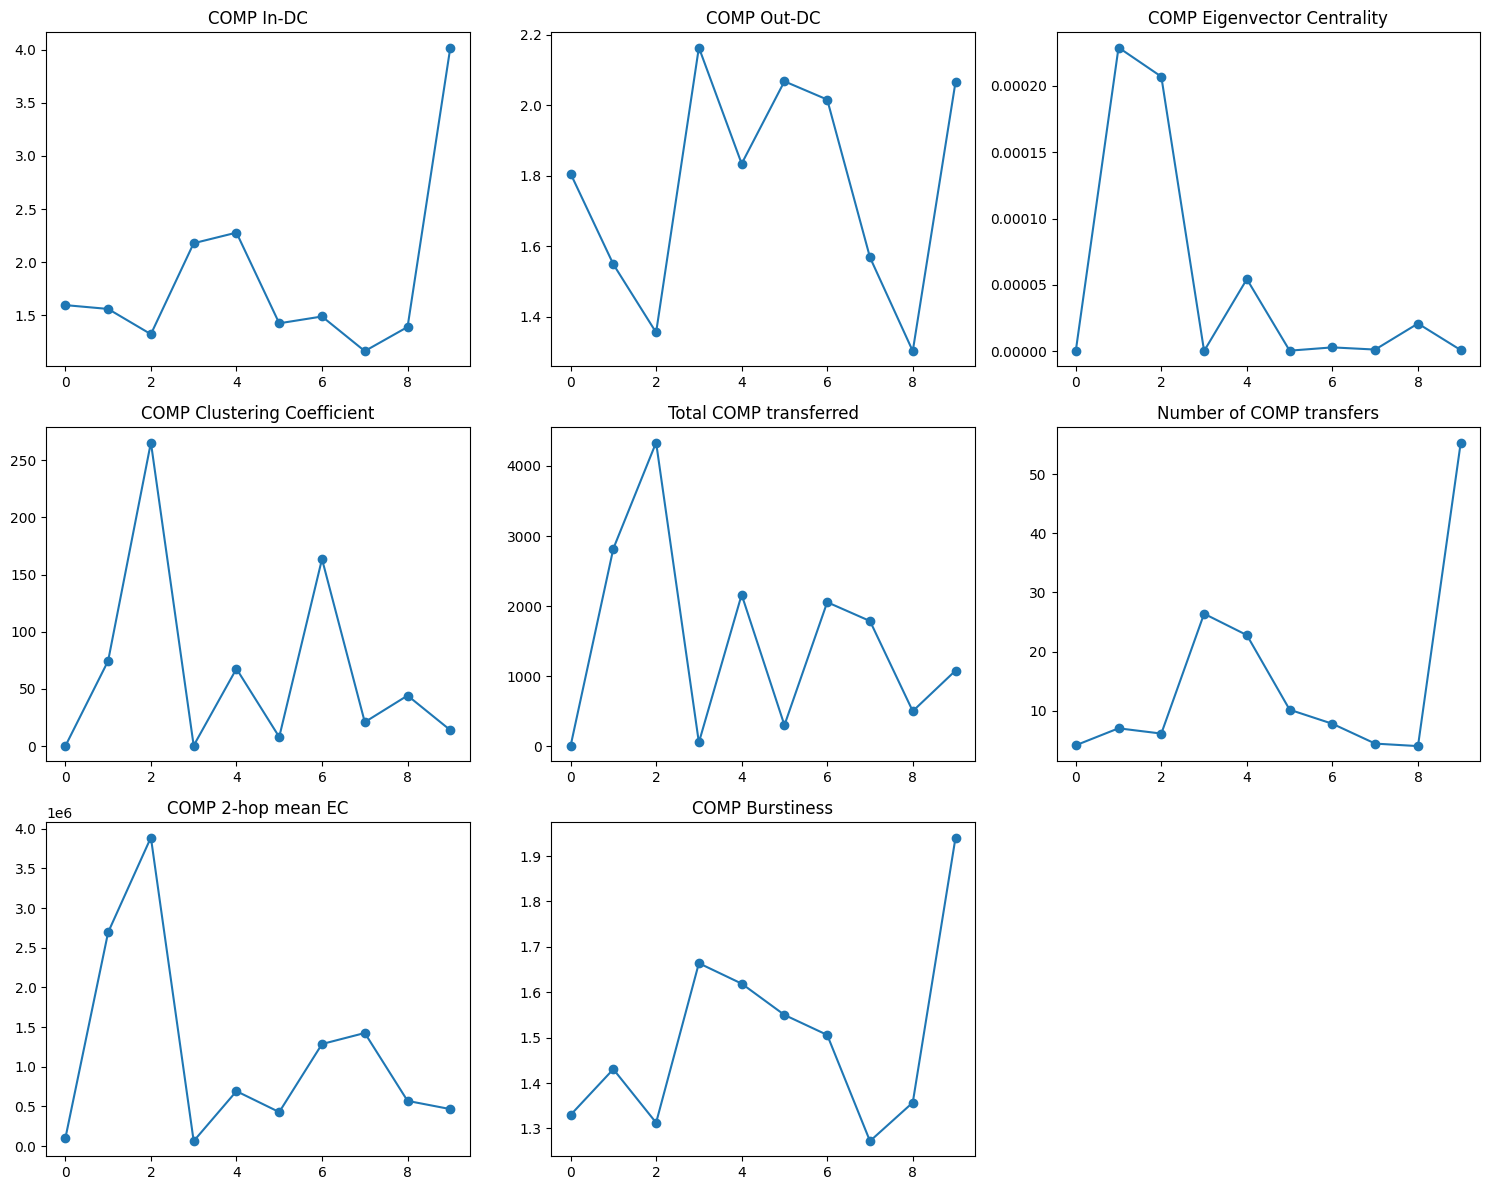

<Figure size 640x480 with 0 Axes>

In [62]:
plot_per_community(COMP_mappings)

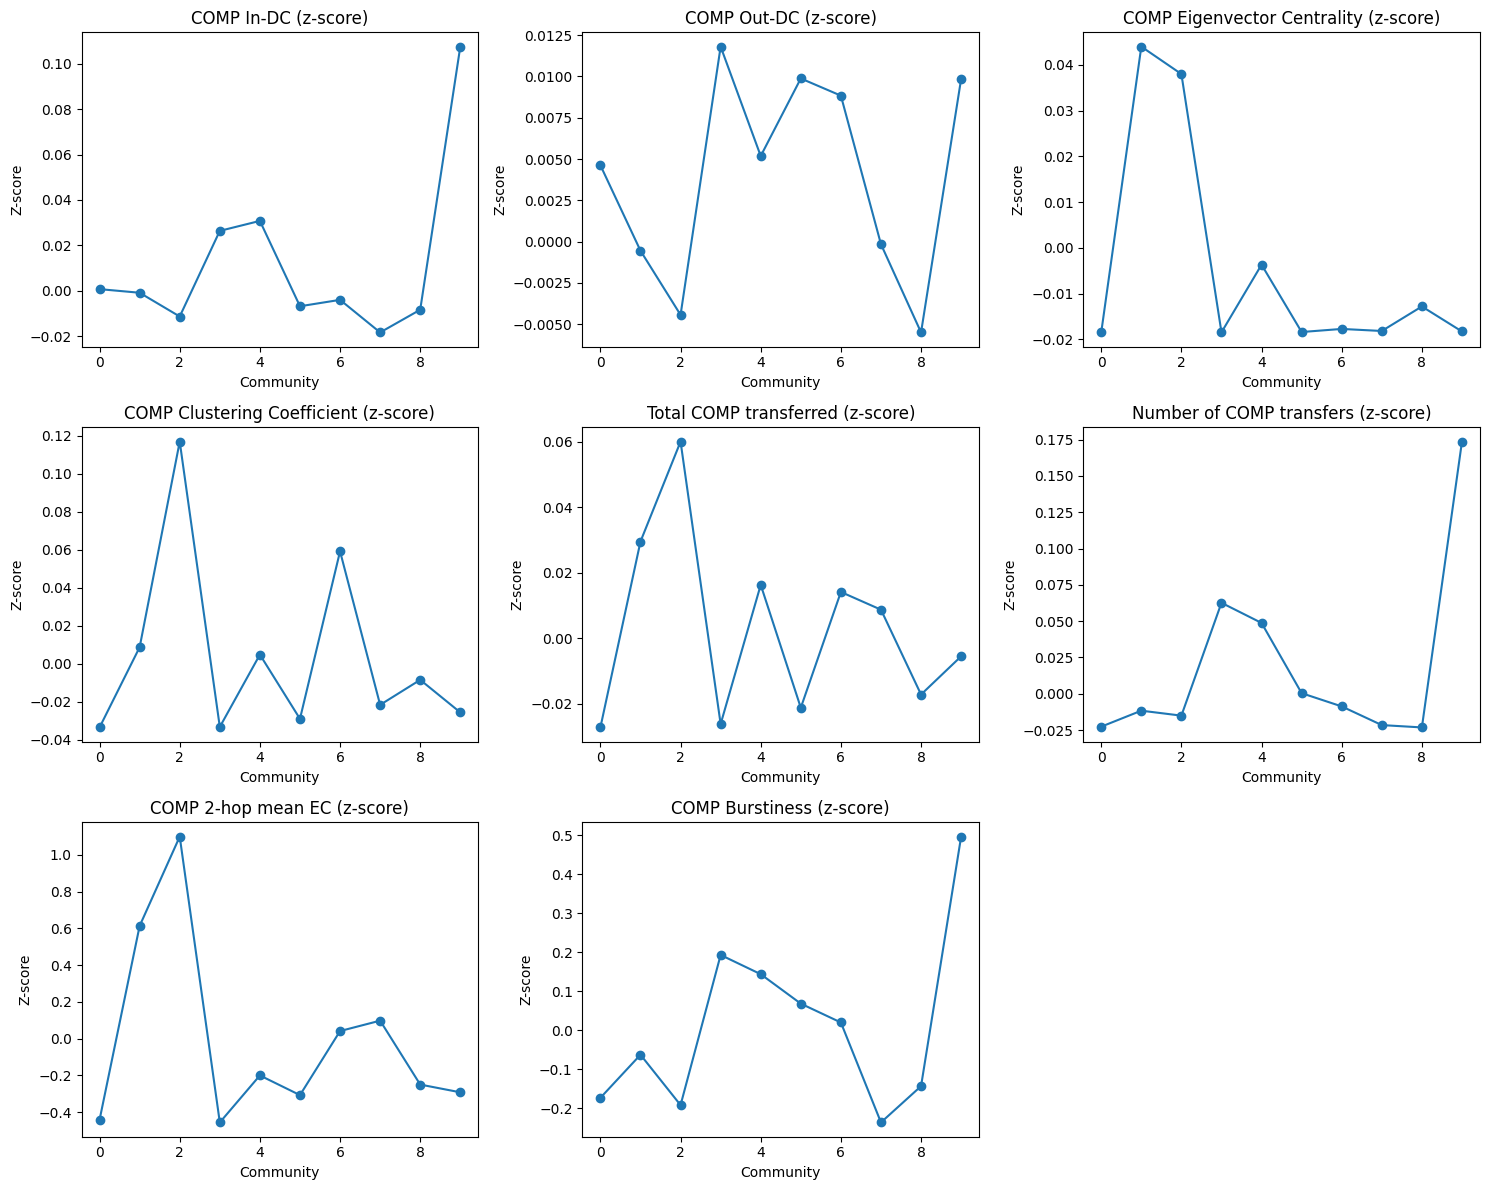

In [63]:
plot_per_community_2(COMP_mappings)

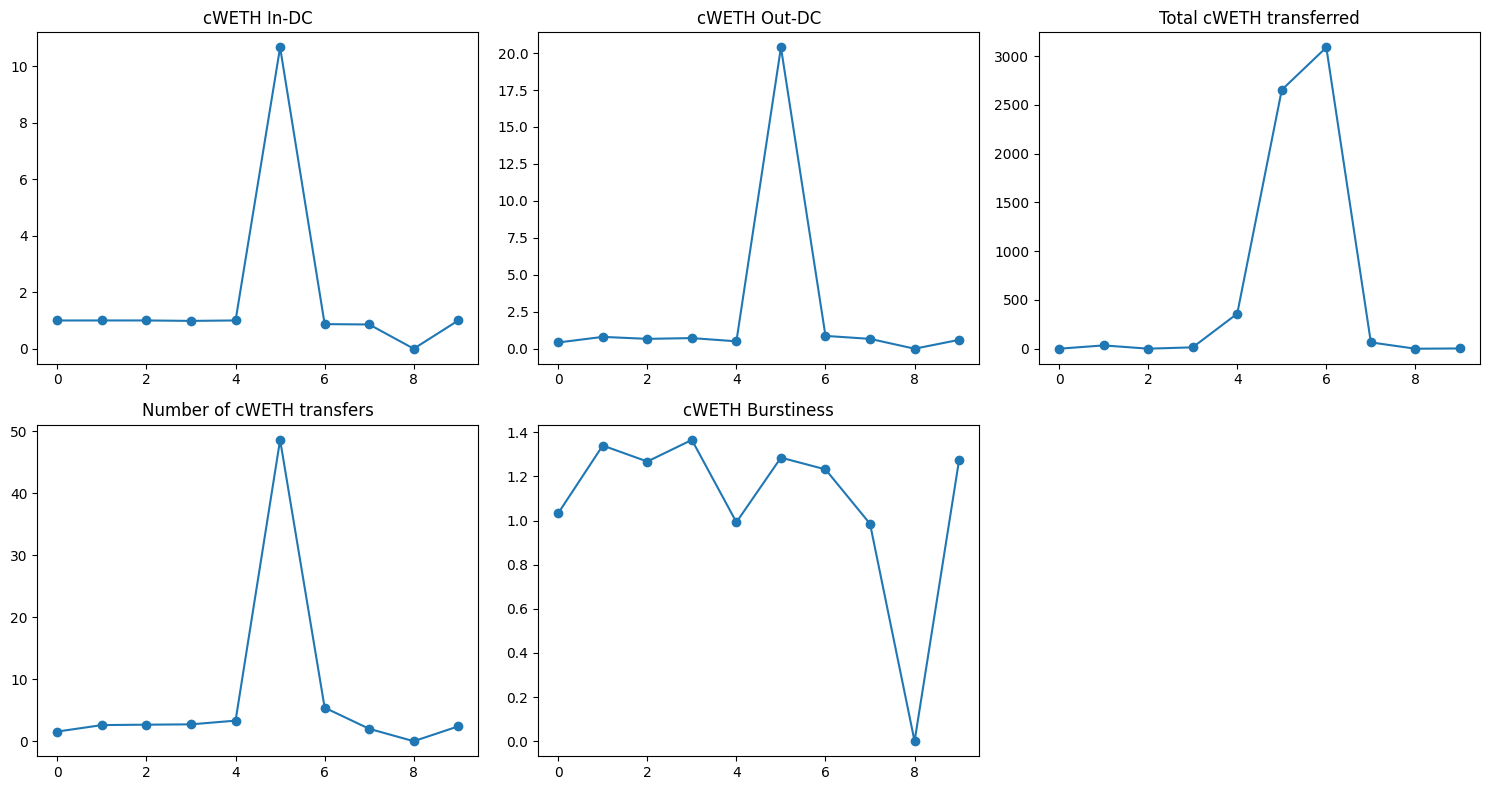

<Figure size 640x480 with 0 Axes>

In [64]:
plot_per_community(cWETH_mappings)

In [ ]:
plot_per_community_2(cWETH_mappings)

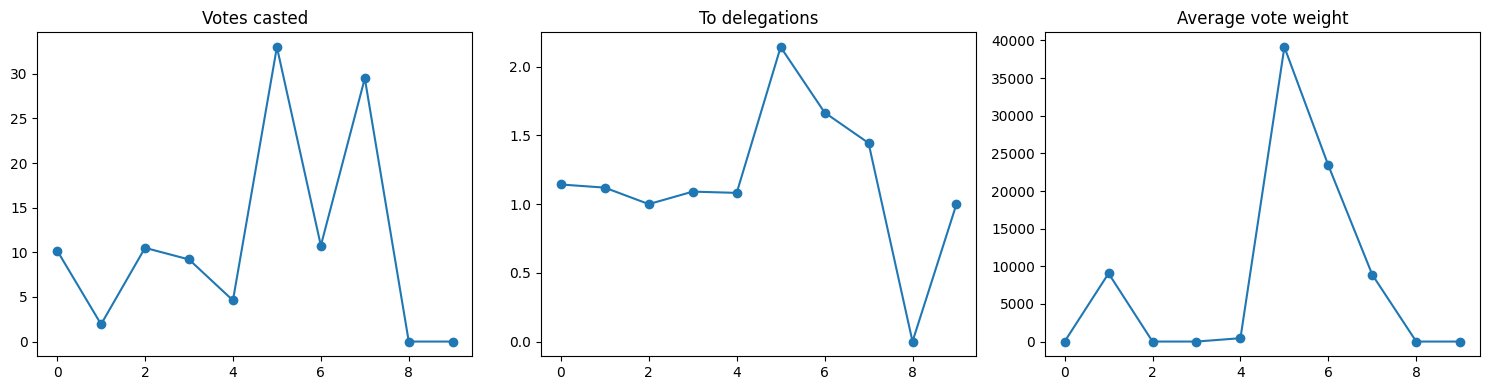

<Figure size 640x480 with 0 Axes>

In [65]:
plot_per_community(gov_mappings)

In [ ]:
plot_per_community_2(gov_mappings)

##### SI influence comparison

#### Applied on G_comp

In [45]:
G_comp_igraph = ig.Graph.from_networkx(G_comp, vertex_attr_hashable='name')

partition = la.find_partition(G_comp_igraph, la.ModularityVertexPartition, weights='weight')

modularity = partition.modularity

print(len(partition), modularity)

3124 0.6345829521012517


In [46]:
community_sizes = [len(c) for c in partition]

sorted_indices = sorted(range(len(community_sizes)), key=lambda i: community_sizes[i], reverse=True)

sorted_communities = [partition[i] for i in sorted_indices]

top_communities = sorted_communities[:10]

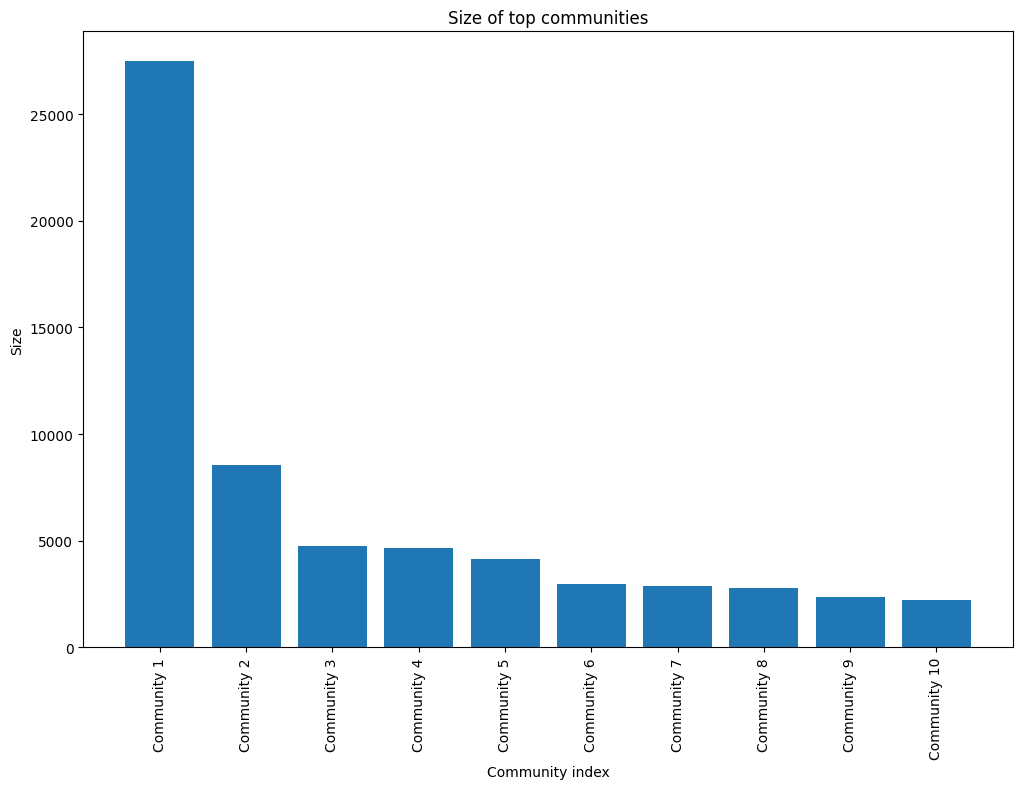

In [47]:
top_communities_sizes = [len(community) for community in top_communities]

plt.figure(figsize=(12, 8))
plt.bar(range(len(top_communities)), top_communities_sizes)
plt.xlabel('Community index')
plt.ylabel('Size')
plt.title('Size of top communities')
plt.xticks(range(len(top_communities)), [f'Community {i+1}' for i in range(len(top_communities))], rotation=90)
plt.show()

In [48]:
community_distribution = {
    'Economic': [],
    'Governance': [],
    'Both': [],
    'None': []
}

communities_with_ids = [
    {G_comp_igraph.vs[idx]["name"] for idx in community} for community in top_communities
]

total_economic_percentage = 0
total_governance_percentage = 0

economic_percentages = []
governance_percentages = []

id = 1
for community in communities_with_ids:
    economic_count = len(only_economic_users & community)
    governance_count = len(only_governance_users & community)
    both_count = len(both_economic_and_governance_users & community)
    none_count = len(community) - economic_count - governance_count - both_count
    
    # total_count = economic_count + governance_count + both_count + none_count
    
    # percentage = ((economic_count + governance_count + both_count) / total_count)*100
    
    economic_count_2 = len(all_economic_users_in_G_comp & community)
    governance_count_2 = len(all_governance_users_in_G_comp & community)
    
    economic_percentage = (economic_count_2 / len(all_economic_users_in_G_comp)) * 100
    governance_percentage = (governance_count_2 / len(all_governance_users_in_G_comp)) * 100
    
    economic_percentages.append(economic_percentage)
    governance_percentages.append(governance_percentage)
    
    total_economic_percentage += economic_percentage
    total_governance_percentage += governance_percentage
    
    print(f'Percentage of all the users in community {id}, economic: {economic_percentage:.0f}%, governance: {governance_percentage:.0f}%')
    
    id += 1
    
    community_distribution['Economic'].append(economic_count)
    community_distribution['Governance'].append(governance_count)
    community_distribution['Both'].append(both_count)
    community_distribution['None'].append(none_count)

print(f'{total_economic_percentage:.1f}%, {total_governance_percentage:.1f}%')


Percentage of all the users in community 1, economic: 93%, governance: 7%
Percentage of all the users in community 2, economic: 1%, governance: 61%
Percentage of all the users in community 3, economic: 0%, governance: 10%
Percentage of all the users in community 4, economic: 0%, governance: 1%
Percentage of all the users in community 5, economic: 5%, governance: 9%
Percentage of all the users in community 6, economic: 0%, governance: 0%
Percentage of all the users in community 7, economic: 0%, governance: 2%
Percentage of all the users in community 8, economic: 0%, governance: 3%
Percentage of all the users in community 9, economic: 0%, governance: 0%
Percentage of all the users in community 10, economic: 0%, governance: 0%
99.4%, 93.0%


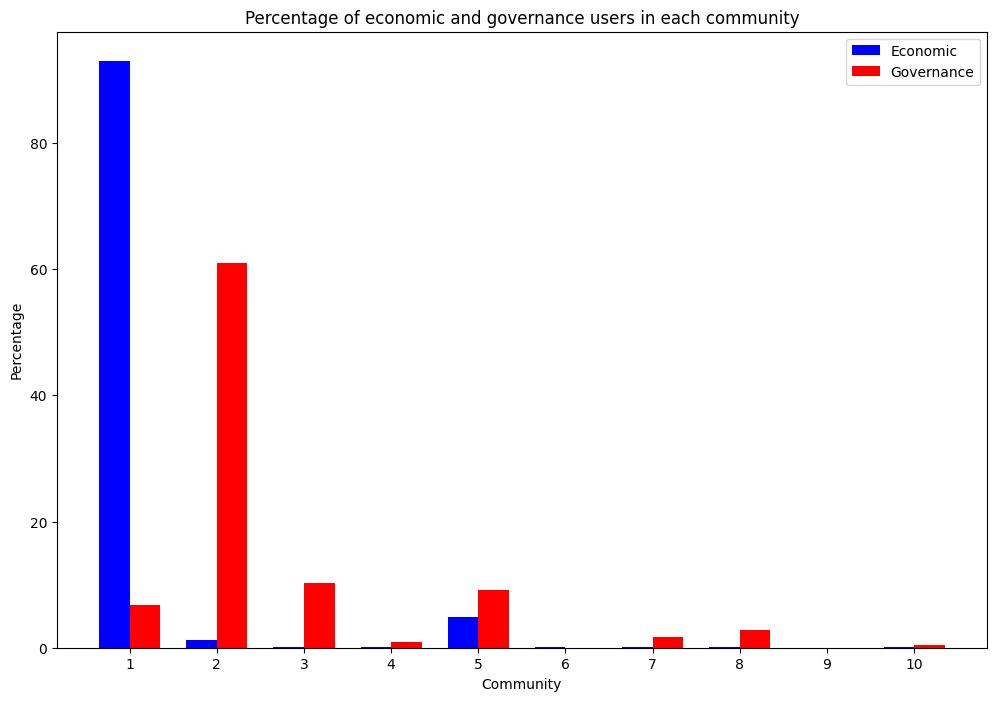

In [50]:
communities = list(range(1, 11))

bar_width = 0.35

r1 = np.arange(len(top_communities))
r2 = [x + bar_width for x in r1]

plt.figure(figsize=(12, 8))
plt.bar(r1, economic_percentages, color='b', width=bar_width, label='Economic')
plt.bar(r2, governance_percentages, color='r', width=bar_width, label='Governance')
plt.xlabel('Community')
plt.ylabel('Percentage')
plt.xticks([r + bar_width/2 for r in range(len(communities))], communities)
plt.title('Percentage of economic and governance users in each community')
plt.legend()
plt.show()

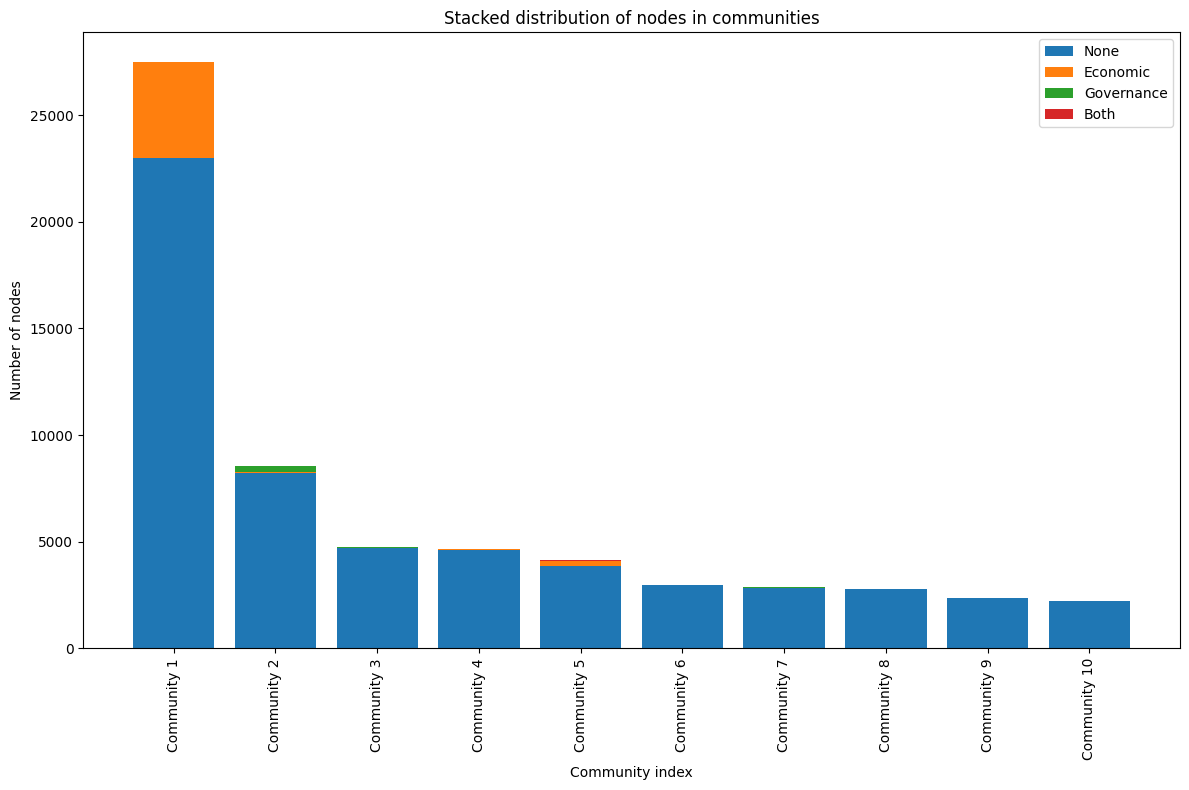

In [49]:
fig, ax = plt.subplots(1, 1, figsize=(12, 8))

bar_width = 0.8
index = np.arange(len(communities_with_ids))

economic_array = np.array(community_distribution['Economic'])
governance_array = np.array(community_distribution['Governance'])
both_array = np.array(community_distribution['Both'])
none_array = np.array(community_distribution['None'])

bar1 = ax.bar(index, none_array, bar_width, label='None')
bar2 = ax.bar(index, economic_array, bar_width, bottom=none_array, label='Economic')
bar3 = ax.bar(index, governance_array, bar_width, bottom=none_array + economic_array, label='Governance')
bar4 = ax.bar(index, both_array, bar_width, bottom=none_array + economic_array + governance_array, label='Both')

ax.set_xlabel('Community index')
ax.set_ylabel('Number of nodes')
ax.set_title('Stacked distribution of nodes in communities')
ax.set_xticks(index)
ax.set_xticklabels([f'Community {i+1}' for i in range(len(communities_with_ids))], rotation=90)
ax.legend()

plt.tight_layout()
plt.show()

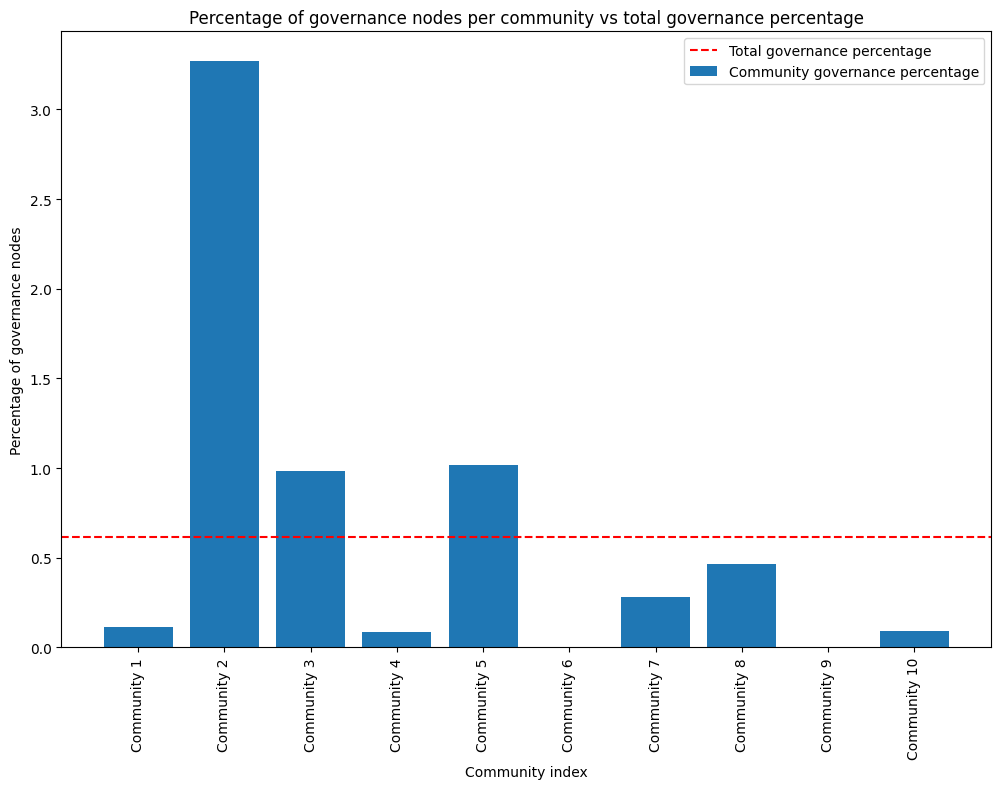

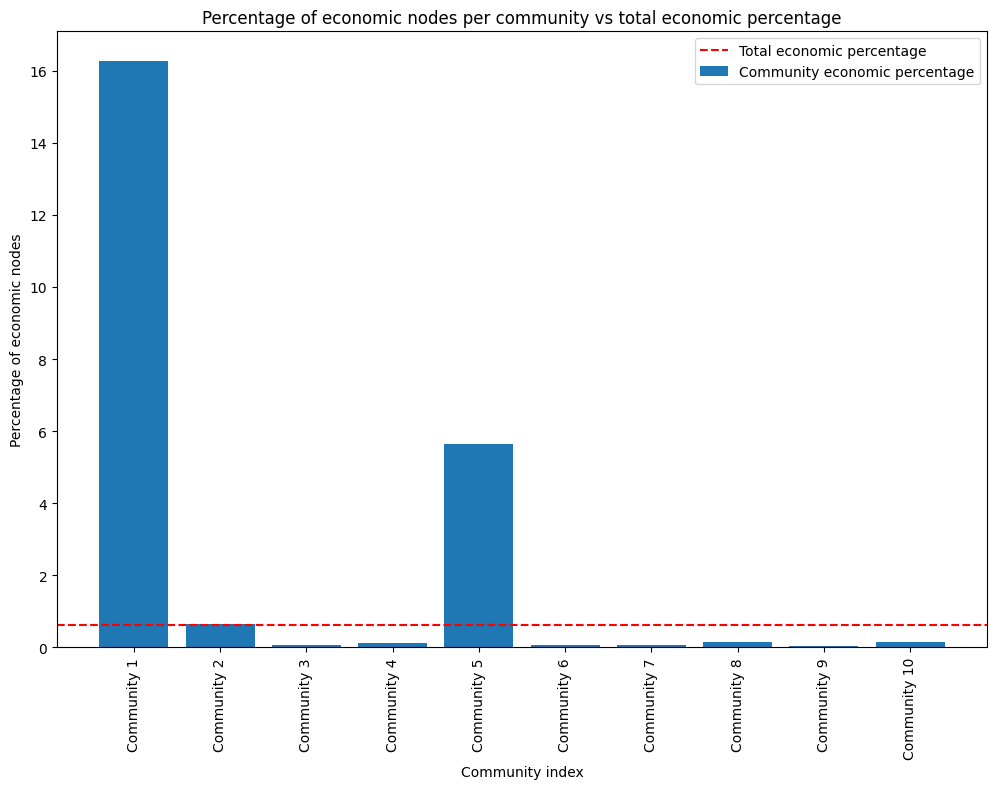

In [52]:
total_governance_percentage = (len(all_governance_users_in_G_comp) / len(G_comp_nodes)) * 100
total_economic_percentage = (len(all_economic_users_in_G_comp) / len(G_comp_nodes)) * 100

community_governance_percentages = []
community_economic_percentages = []
for community in communities_with_ids:
    governance_count = len(community & all_governance_users_in_G_comp)
    community_percentage = (governance_count / len(community)) * 100
    community_governance_percentages.append(community_percentage)
    
    economic_count = len(community & all_economic_users_in_G_comp)
    economic_percentage = (economic_count / len(community)) * 100
    community_economic_percentages.append(economic_percentage)

plt.figure(figsize=(12, 8))
plt.bar(range(len(top_communities)), community_governance_percentages, label='Community governance percentage')
plt.axhline(y=total_governance_percentage, color='r', linestyle='--', label='Total governance percentage')
plt.xlabel('Community index')
plt.ylabel('Percentage of governance nodes')
plt.title('Percentage of governance nodes per community vs total governance percentage')
plt.legend()
plt.xticks(range(len(top_communities)), [f'Community {i+1}' for i in range(len(top_communities))], rotation=90)
plt.show()

plt.figure(figsize=(12, 8))
plt.bar(range(len(top_communities)), community_economic_percentages, label='Community economic percentage')
plt.axhline(y=total_governance_percentage, color='r', linestyle='--', label='Total economic percentage')
plt.xlabel('Community index')
plt.ylabel('Percentage of economic nodes')
plt.title('Percentage of economic nodes per community vs total economic percentage')
plt.legend()
plt.xticks(range(len(top_communities)), [f'Community {i+1}' for i in range(len(top_communities))], rotation=90)
plt.show()

## SI

In [66]:
def normalize_weights(G):
    max_weight = max(data['weight'] for _, _, _, data in G.edges(keys=True, data=True))
    
    for _, _, _, data in G.edges(keys=True, data=True):
        data['norm_weight'] = data['weight'] / max_weight
    
    return G

def log_normalize_weights(G):
    max_weight = np.log1p(max(data['weight'] for _, _, _, data in G.edges(keys=True, data=True)))
    
    for _, _, _, data in G.edges(keys=True, data=True):
        data['norm_weight'] = np.log1p(data['weight']) / max_weight
    
    return G

### Simple SI model

In [69]:
G = copy.deepcopy(G_comp_complete)
G_T = copy.deepcopy(G_comp_complete)

G = log_normalize_weights(G)
G_T = normalize_weights(G_T)

In [68]:
def preprocess_out_edges(G, beta=1.0):
    out_edges = defaultdict(list)
    
    for u, v, k, d in G.edges(keys=True, data=True):
        out_edges[u].append((v, d['timestamp'], beta * d['norm_weight']))
    
    return out_edges

def simulate_SI(G, seed_node, beta=1.0, cached_edges=None):
    infected = {}
    infection_queue = []

    infected[seed_node] = 1696118400
    heapq.heappush(infection_queue, (1696118400, seed_node))

    while infection_queue:
        curr_time, node = heapq.heappop(infection_queue)
        
        if node not in cached_edges:
            continue
        
        for neighbor, ts, prob in cached_edges[node]:
        # for _, neighbor, _, data in G.out_edges(node, keys=True, data=True):
            if neighbor in infected:
                continue
            
            # ts = data['timestamp']
            # prob = beta * data['norm_weight']

            if ts >= curr_time:
                if np.random.rand() < prob:
                    infected[neighbor] = ts
                    heapq.heappush(infection_queue, (ts, neighbor))

    return infected

def run_multiple_iterations(G, num_iterations=100, beta=1.0):
    all_nodes = list(G.nodes)
    infection_counts = defaultdict(list)
    infections_per_iteration = defaultdict(list)
    
    cached_edges = preprocess_out_edges(G, beta)

    for i in range(num_iterations):
        print(f"Iteration {i+1}/{num_iterations}")
        # for seed in tqdm(all_nodes, desc=f"SI iteration {i+1}"):
        for seed in all_nodes:
            infected = simulate_SI(G, seed, beta, cached_edges)
            infection_counts[seed].append(len(infected))
            infections_per_iteration[seed].append(infected)

    avg_results = [{
        'seed': node,
        'avg_infected': sum(counts) / len(counts),
        'infections_per_iteration': infections_per_iteration[node]
        # 'all_infected_counts': counts
    } for node, counts in infection_counts.items()]

    top_avg_influencers = sorted(avg_results, key=lambda x: x['avg_infected'], reverse=True)

    return top_avg_influencers

### Simulations

In [ ]:
SI_T_001 = run_multiple_iterations(G_T, num_iterations=10, beta=0.01)

with open('COMP_SI_T_001.pkl', 'wb') as file:
    pickle.dump(SI_T_001, file)

Iteration 1/10
Iteration 2/10
Iteration 3/10
Iteration 4/10
Iteration 5/10
Iteration 6/10
Iteration 7/10
Iteration 8/10
Iteration 9/10
Iteration 10/10


In [72]:
SI_T_01 = run_multiple_iterations(G_T, num_iterations=10, beta=0.1)

with open('COMP_SI_T_01.pkl', 'wb') as file:
    pickle.dump(SI_T_01, file)

Iteration 1/10
Iteration 2/10
Iteration 3/10
Iteration 4/10
Iteration 5/10
Iteration 6/10
Iteration 7/10
Iteration 8/10
Iteration 9/10
Iteration 10/10


In [73]:
SI_T_05 = run_multiple_iterations(G_T, num_iterations=10, beta=0.5)

with open('COMP_SI_T_05.pkl', 'wb') as file:
    pickle.dump(SI_T_05, file)

Iteration 1/10
Iteration 2/10
Iteration 3/10
Iteration 4/10
Iteration 5/10
Iteration 6/10
Iteration 7/10
Iteration 8/10
Iteration 9/10
Iteration 10/10


In [74]:
SI_T_1 = run_multiple_iterations(G_T, num_iterations=10, beta=1.0)

with open('COMP_SI_T_1.pkl', 'wb') as file:
    pickle.dump(SI_T_1, file)

Iteration 1/10
Iteration 2/10
Iteration 3/10
Iteration 4/10
Iteration 5/10
Iteration 6/10
Iteration 7/10
Iteration 8/10
Iteration 9/10
Iteration 10/10


In [ ]:
SI_001 = run_multiple_iterations(G, num_iterations=10, beta=0.01)

with open('COMP_SI_001.pkl', 'wb') as file:
    pickle.dump(SI_001, file)

Iteration 1/10
Iteration 2/10
Iteration 3/10
Iteration 4/10
Iteration 5/10
Iteration 6/10
Iteration 7/10
Iteration 8/10
Iteration 9/10
Iteration 10/10


In [ ]:
SI_01 = run_multiple_iterations(G, num_iterations=10, beta=0.1)

with open('COMP_SI_01.pkl', 'wb') as file:
    pickle.dump(SI_01, file)

Iteration 1/10
Iteration 2/10
Iteration 3/10
Iteration 4/10
Iteration 5/10
Iteration 6/10
Iteration 7/10
Iteration 8/10
Iteration 9/10
Iteration 10/10


In [77]:
SI_05 = run_multiple_iterations(G, num_iterations=10, beta=0.5)

with open('COMP_SI_05.pkl', 'wb') as file:
    pickle.dump(SI_05, file)

Iteration 1/10
Iteration 2/10
Iteration 3/10
Iteration 4/10
Iteration 5/10
Iteration 6/10
Iteration 7/10
Iteration 8/10
Iteration 9/10
Iteration 10/10


In [83]:
SI_1 = run_multiple_iterations(G, num_iterations=10, beta=1.0)

with open('COMP_SI_1.pkl', 'wb') as file:
    pickle.dump(SI_1, file)

Iteration 1/10
Iteration 2/10
Iteration 3/10
Iteration 4/10
Iteration 5/10
Iteration 6/10
Iteration 7/10
Iteration 8/10
Iteration 9/10
Iteration 10/10


In [78]:
SI_001_extracted = [{'seed': entry['seed'], 'avg_infected': entry['avg_infected']} for entry in SI_001]

with open('COMP_SI_001_extracted_seeds_avg_infected.pkl', 'wb') as new_file:
    pickle.dump(SI_001_extracted, new_file)
    
SI_01_extracted = [{'seed': entry['seed'], 'avg_infected': entry['avg_infected']} for entry in SI_01]

with open('COMP_SI_01_extracted_seeds_avg_infected.pkl', 'wb') as new_file:
    pickle.dump(SI_01_extracted, new_file)
    
SI_05_extracted = [{'seed': entry['seed'], 'avg_infected': entry['avg_infected']} for entry in SI_05]

with open('COMP_SI_05_extracted_seeds_avg_infected.pkl', 'wb') as new_file:
    pickle.dump(SI_05_extracted, new_file)

In [84]:
SI_1_extracted = [{'seed': entry['seed'], 'avg_infected': entry['avg_infected']} for entry in SI_1]

with open('COMP_SI_1_extracted_seeds_avg_infected.pkl', 'wb') as new_file:
    pickle.dump(SI_1_extracted, new_file)

### Analysis

In [79]:
SI_001_outcome = joblib.load('COMP_SI_001_extracted_seeds_avg_infected.pkl')
SI_01_outcome = joblib.load('COMP_SI_01_extracted_seeds_avg_infected.pkl')
SI_05_outcome = joblib.load('COMP_SI_05_extracted_seeds_avg_infected.pkl')
# SI_1_outcome = joblib.load('COMP_SI_1_extracted_seeds_avg_infected.pkl')

# SI_T_01_outcome = joblib.load('SI_T_01.pkl')
# SI_T_001_outcome = joblib.load('SI_T_001.pkl')
# SI_T_05_outcome = joblib.load('SI_T_05.pkl')
# SI_T_1_outcome = joblib.load('SI_T_1.pkl')

In [80]:
avg_infected_001 = [entry['avg_infected'] for entry in SI_001_outcome]
avg_infected_01 = [entry['avg_infected'] for entry in SI_01_outcome]
avg_infected_05 = [entry['avg_infected'] for entry in SI_05_outcome]
# avg_infected_1 = [entry['avg_infected'] for entry in SI_1_outcome]

# avg_infected_001_T = [entry['avg_infected'] for entry in SI_T_001_outcome]
# avg_infected_01_T = [entry['avg_infected'] for entry in SI_T_01_outcome]
# avg_infected_05_T = [entry['avg_infected'] for entry in SI_T_05_outcome]
# avg_infected_1_T = [entry['avg_infected'] for entry in SI_T_1_outcome]

In [81]:
influence_scores = {
    '0.01': {seed['seed']: seed['avg_infected'] for seed in SI_001_outcome},
    '0.1': {seed['seed']: seed['avg_infected'] for seed in SI_01_outcome},
    '0.5': {seed['seed']: seed['avg_infected'] for seed in SI_05_outcome},
    # '1.0': {seed['seed']: seed['avg_infected'] for seed in SI_1_outcome}
}

influence_df = pd.DataFrame(influence_scores)

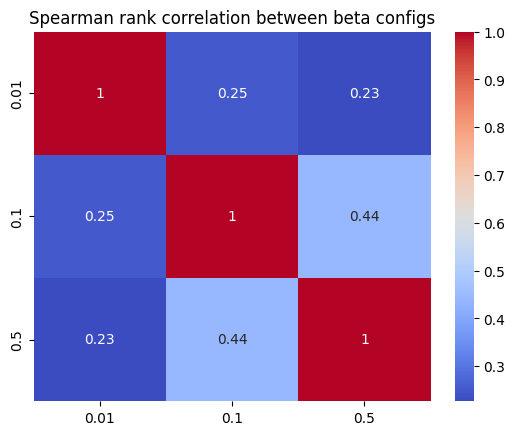

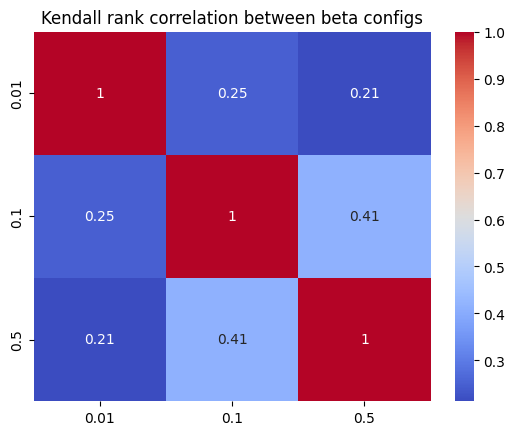

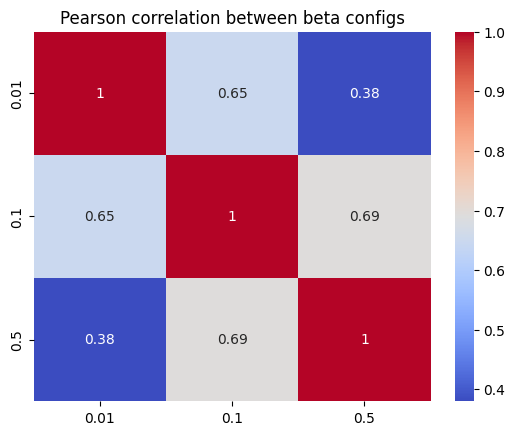

In [82]:
spearman_corr = influence_df.corr(method='spearman')
kendall_corr = influence_df.corr(method='kendall')
pearson_corr = influence_df.corr(method='pearson')

sns.heatmap(spearman_corr, annot=True, cmap="coolwarm")
plt.title("Spearman rank correlation between beta configs")
plt.show()

sns.heatmap(kendall_corr, annot=True, cmap="coolwarm")
plt.title("Kendall rank correlation between beta configs")
plt.show()

sns.heatmap(pearson_corr, annot=True, cmap="coolwarm")
plt.title("Pearson correlation between beta configs")
plt.show()